In [2]:
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import os
import re
import math
import matplotlib.ticker as tck
import glob
import statsmodels.api as sm


Loading files

In [319]:
paths = glob.glob(os.path.join("E:/Turku_collab/lunagel_50s/remodelling", "**","summary_ID_level.csv"),recursive=True)
print(*paths, sep='\n')
cell_info = (pd.read_csv("E:/Turku_collab/lunagel_50s/remodelling/cell_info.csv")).drop(columns=['Unnamed: 0'])

E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\0_241111\241111_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\120\1_241125\241125_10um_3layers_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\0_241107\241107_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_MDAMB231\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodelling\24_120\24\1_241121\241121_10um_3layer_50s_control\results\summary_ID_level.csv
E:/Turku_collab/lunagel_50s/remodellin

In [360]:
def parser(i):
    data = pd.read_csv(i)
    data['irradiation'] = (i.split('/')[2].split('_')[1])       
    data['incubation_set'] = i.split('/')[3].split('\\')[1]
    data['incubation'] = i.split('/')[3].split('\\')[2]
    print(i.split('/')[3].split('\\')[2])
    data['experiment'] = i.split('/')[3].split('\\')[3].split('_')[0]
    data['cell/control'] = i.split('/')[3].split('\\')[4].split('_')[-1]
    data['day'] = data['day'].astype(str)
    max_location = data['location'].unique().max()
    
    data['location_inverse'] = max_location + 1 - data['location']

    for j, location in enumerate(data['location'].unique()):
        # Use .loc to properly assign values to the dataframe
        data.loc[data['location'] == location, 'gradient'] = data['y'] + location*665.6
        data.loc[data['location'] == location, 'gradient_inverse'] = data['y'] + (max_location-location)*665.6
    return data
  
df=[]
df = pd.concat([parser(i) for i in paths], ignore_index=True)

120
120
120
120
24
24
24
24
48
48
48
48
144
144
144
144
0
0
168


In [361]:
df['gradient_direction'] = np.where(
    ((df['sample'] == "MDAMB231") & (df['day'] == "241107")) | 
    (df['day'].isin(["241121","241122", "241125","241126","240830"])),
    "stiff_to_soft",
    "soft_to_stiff"
)

Generating file with beads close-by to cells (6h movement = 664 µm radius)

In [362]:
#parameters for selection of close-by beads
time = 180 #min
speed = 0.5 # or 0.6µm/min
pixel_size = 0.325 #µm
distance = time*speed/pixel_size
print(distance)

276.9230769230769


In [363]:
grouped_all = df.groupby(['day', 'sample', 'holder', 'location'])
grouped_cell = cell_info.groupby(['day', 'sample', 'holder', 'location'])
closeby = []
faraway = []
#looping through groups in both files
for key_all,j_all in grouped_all:
    for key_cell, j_cell in grouped_cell:
        #check if the groups match
        if key_all == key_cell:
            # Each bead of the group and comparing to the distance to each cell
            for index_all, row_all in j_all.iterrows():
                for index_all, row_all in j_all.iterrows():
                    bead_classified = False  # Flag to track if bead is classified
                    for index_cell, row_cell in j_cell.iterrows():
                        if ((row_cell['x'] - distance) < row_all['x'] < (row_cell['x'] + distance)) and \
                        ((row_cell['y'] - distance) < row_all['y'] < (row_cell['y'] + distance)):
                            closeby.append(row_all)
                            bead_classified = True
                            break  # Exit loop once bead is classified as closeby
                    if not bead_classified:
                        faraway.append(row_all)
final_closeby = pd.DataFrame(closeby)
final_faraway = pd.DataFrame(faraway)

print(final_closeby.shape)
print(final_faraway.shape)

(0, 0)
(0, 0)


Saving files

In [364]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'

#Data_all and data_cell-closeby-beads including gradient direction
df.to_csv(saving_path+'/gradients.csv')  
final_closeby.to_csv(saving_path+'/gradients_closeby.csv') 
final_faraway.to_csv(saving_path+'/gradients_faraway.csv') 



Loading files

In [365]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
download = pd.read_csv(saving_path +'/gradients.csv', index_col=None)
download_closeby = pd.read_csv(saving_path +'/gradients_closeby.csv', index_col=None)
download_faraway = pd.read_csv(saving_path +'/gradients_faraway.csv', index_col=None)



In [366]:
download.columns

Index(['Unnamed: 0', 'day', 'sample', 'holder', 'location', 'track_id',
       'reference_id', 'distance(um)', 'Cov_Sum', 'a_(um)', 'phi_(rad)', 'c',
       'd', 'G_abs', 'radius_(m)', 'rmse', 'inv.rmse', 'shift_(s)', 'a_error',
       'phi_error', 'c_error', 'd_error', 'x', 'y', 'repeat', 'phi_(deg)',
       'tan_phi', 'irradiation', 'incubation_set', 'incubation', 'experiment',
       'cell/control', 'location_inverse', 'gradient', 'gradient_inverse',
       'gradient_direction'],
      dtype='object')

In [367]:
download['gradient_direction'].unique()

array(['soft_to_stiff', 'stiff_to_soft'], dtype=object)

In [368]:
print(download['experiment'].unique())
print(download['day'].unique())
print(download['holder'].unique())
print(download['irradiation'].unique())
print(download['cell/control'].unique())
print(download['holder'].unique())
print(download['incubation_set'].unique())
print(download['incubation'].unique())

download

[0 1]
[241111 241125 241107 241121 241108 241122 241112 241126 240823 240830]
[1 2]
['50s']
['MDAMB231' 'control']
[1 2]
['24_120' '48_144' '0_168']
[120  24  48 144   0 168]


Unnamed: 0     day  sample  holder  location  track_id  reference_id  \
0             0  241111       1       1         1         0      1.666667   
1             1  241111       1       1         1         1      0.000000   
2             2  241111       1       1         1         2      3.000000   
3             3  241111       1       1         1         3      4.000000   
4             4  241111       1       1         1         4      4.000000   
..          ...     ...     ...     ...       ...       ...           ...   
970         970  240830       1       1         2         2      2.750000   
971         971  240830       1       1         3         0     15.555556   
972         972  240830       1       1         3         2     19.666667   
973         973  240830       1       1         3         3      6.000000   
974         974  240830       1       1         3         5      9.000000   

     distance(um)   Cov_Sum    a_(um)  ...   tan_phi  irradiation  \
0      155.067151  0.000112  0.300945  ...  0.088836          50s   
1      167.096833  0.001124  0.058844  ...  1.084805          50s   
2      241.806588  0.000143  0.691531  ...  0.092177          50s   
3      109.462938  0.000196  0.138511  ...  0.005060          50s   
4       79.167506  0.000257  0.185188  ... -0.007854          50s   
..            ...       ...       ...  ...       ...          ...   
970    163.110242  0.001279  4.523686  ...  0.037988          50s   
971    122.556849  0.000055  2.165256  ...  0.075721          50s   
972    124.219918  0.000187  1.237455  ...  0.021393          50s   
973    119.513810  0.000106  0.786792  ...  0.172805          50s   
974    210.146746  0.000180  1.634001  ...  0.143142          50s   

     incubation_set  incubation  experiment  cell/control  location_inverse  \
0            24_120         120           0      MDAMB231                 6   
1            24_120         120           0      MDAMB231                 6   
2            24_120         120           0      MDAMB231                 6   
3            24_120         120           0      MDAMB231                 6   
4            24_120         120           0      MDAMB231                 6   
..              ...         ...         ...           ...               ...   
970           0_168         168           0      MDAMB231                 2   
971           0_168         168           0      MDAMB231                 1   
972           0_168         168           0      MDAMB231                 1   
973           0_168         168           0      MDAMB231                 1   
974           0_168         168           0      MDAMB231                 1   

        gradient  gradient_inverse  gradient_direction  
0     976.834105       3639.234105       soft_to_stiff  
1     924.245045       3586.645045       soft_to_stiff  
2     707.191303       3369.591303       soft_to_stiff  
3     921.103152       3583.503152       soft_to_stiff  
4    1093.041567       3755.441567       soft_to_stiff  
..           ...               ...                 ...  
970  1374.216496        708.616496       stiff_to_soft  
971  2118.236489        121.436489       stiff_to_soft  
972  2285.596075        288.796075       stiff_to_soft  
973  2511.727438        514.927438       stiff_to_soft  
974  2561.726627        564.926627       stiff_to_soft  

[975 rows x 36 columns]

## GLS model

In [369]:
alpha = 0.05
def GLS_g(data,ax, color):
    x= data['gradient'].values.reshape(-1,1)
    y= np.log(data['G_abs'])

    # Fit GLS model
    x_const = sm.add_constant(x)  # adds a column of ones to independent variable - allows to estimate the intercept
    
    #Fitting the model to the data
    modelGLS = sm.GLS(y,x_const)

    #Model parameters
    resultsGSL = modelGLS.fit()
    #print(resultsGSL.summary())

    #CI
    confidence_intervals = resultsGSL.conf_int(alpha=0.05)

    # Generate predictions for the original data
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  # Model x-space
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)  # Add constant for predictions

    # Prediction of y based on the model
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)  # Get predictions
    y_predictedGLS = np.exp(y_predictedGLS_log)  # Transform back from log scale

    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # CI for the predictions
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)  #

    ax.scatter(data['f'],data['G_abs'],s=4, c=color) #measured from soft to stiff
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')  # Fitted line
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI,
                         #color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim (0,100) 
    ax.set_xlim (0,5000)  

    #print(resultsGSL.bse)


In [370]:
from scipy.optimize import curve_fit

def fitting(ax,x_data, y_data,color_type,marker_type):
    
    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    k_guess = 0.1  # initial slope estimate, a smaller value usually works
    L_guess = np.max(y_data) 
    k_guess = 0.1
    x0_guess = 2500
    params, _ = curve_fit(logistic_func, x_data, y_data,p0=[L_guess, k_guess, x0_guess], maxfev=10000)
    L, k, x0 = params

    # Display the fitted parameters
    print(f'Fitted parameters: L = {L:.3f}, k = {k:.3f}, x0 = {x0:.3f}')

    # Plot the data and the fitted logistic curve
    ax.scatter(x_data, y_data, label='Data', s=35,c=color_type, marker=marker_type)
    #ax.plot(x_data, logistic_func(x_data, *params), label=f'Logistic fit: L={L:.3f}, k={k:.3f}, x0={x0:.3f}', color=color_type)



Plotting G

Kernel Ridge Regression

Continuous

In [426]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

def fitting_kernel(x, y, ax,alpha, color, marker):
    x_reshaped = x.values.reshape(-1, 1)  #     # Reshape x to a 2D array (required for scikit-learn models), converts x into a 2D array with shape (n_samples, 1)
    y_reshaped = y.values 
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_reshaped) 
    
    # Initialize Kernel Ridge Regression model
    # similarity between two points in higher-dimensional space = this is done using a kernel function, here Radial Basis Function (RBF) kernel
    # ALPHA = regularization factor
    krr = KernelRidge(kernel='rbf', alpha=alpha)  # A larger --> more regularization; model prioritizes simpler solutions fitting general trend and not capture smaller details
    # Fit the model with the given data
    krr.fit(x_scaled, y_reshaped)

    # Grid of x values for the kernel fit (scaled)
    x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 1000)[:, np.newaxis]  # Fine grid for prediction
    y_fit = krr.predict(x_fit)  # Predict the y values for the fine grid

    # Rescale x_fit back to original scale for plotting
    x_fit_original = scaler.inverse_transform(x_fit)  # Rescale the x values back

    # Plot the original data as a scatter plot
    ax.scatter(x_reshaped, y_reshaped, label='Original Data', color=color, marker=marker)
    #ax.boxplot(x_reshaped, y_reshaped, label='Original Data')

    # Plot the kernel fit (the kernel regression curve)
    ax.plot(x_fit_original, y_fit,color=color, label='Kernel Fit', linewidth=3)






Binned

In [372]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

def fitting_kernel_bin(x, y, ax, color_type,alpha):
    x_reshaped = x.values.reshape(-1, 1)  #     # Reshape x to a 2D array (required for scikit-learn models), converts x into a 2D array with shape (n_samples, 1)
    y_reshaped = y.values 
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_reshaped)  
    
    # Initialize Kernel Ridge Regression model
    # similarity between two points in higher-dimensional space = this is done using a kernel function, here Radial Basis Function (RBF) kernel
    # ALPHA = regularization factor
    krr = KernelRidge(kernel='rbf', alpha=alpha)  # A larger --> more regularization; model prioritizes simpler solutions fitting general trend and not capture smaller details
    # Fit the model with the given data
    krr.fit(x_scaled, y_reshaped)

    # Grid of x values for the kernel fit (scaled)
    x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 1000)[:, np.newaxis]  # Fine grid for prediction
    y_fit = krr.predict(x_fit)  # Predict the y values for the fine grid

    # Rescale x_fit back to original scale for plotting
    x_fit_original = scaler.inverse_transform(x_fit)  # Rescale the x values back

    # Plot the original data as a scatter plot
    #ax.scatter(x_reshaped, y_reshaped, label='Original Data', color=color_type, marker=marker_type)

    # sns.boxplot(dd, label='Original Data', color=color_type,ax=ax)
    # # Plot the kernel fit (the kernel regression curve)
    ax.plot(x_fit_original, y_fit,color=color_type, label='Kernel Fit', linewidth=3)






Continous plot by distance

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

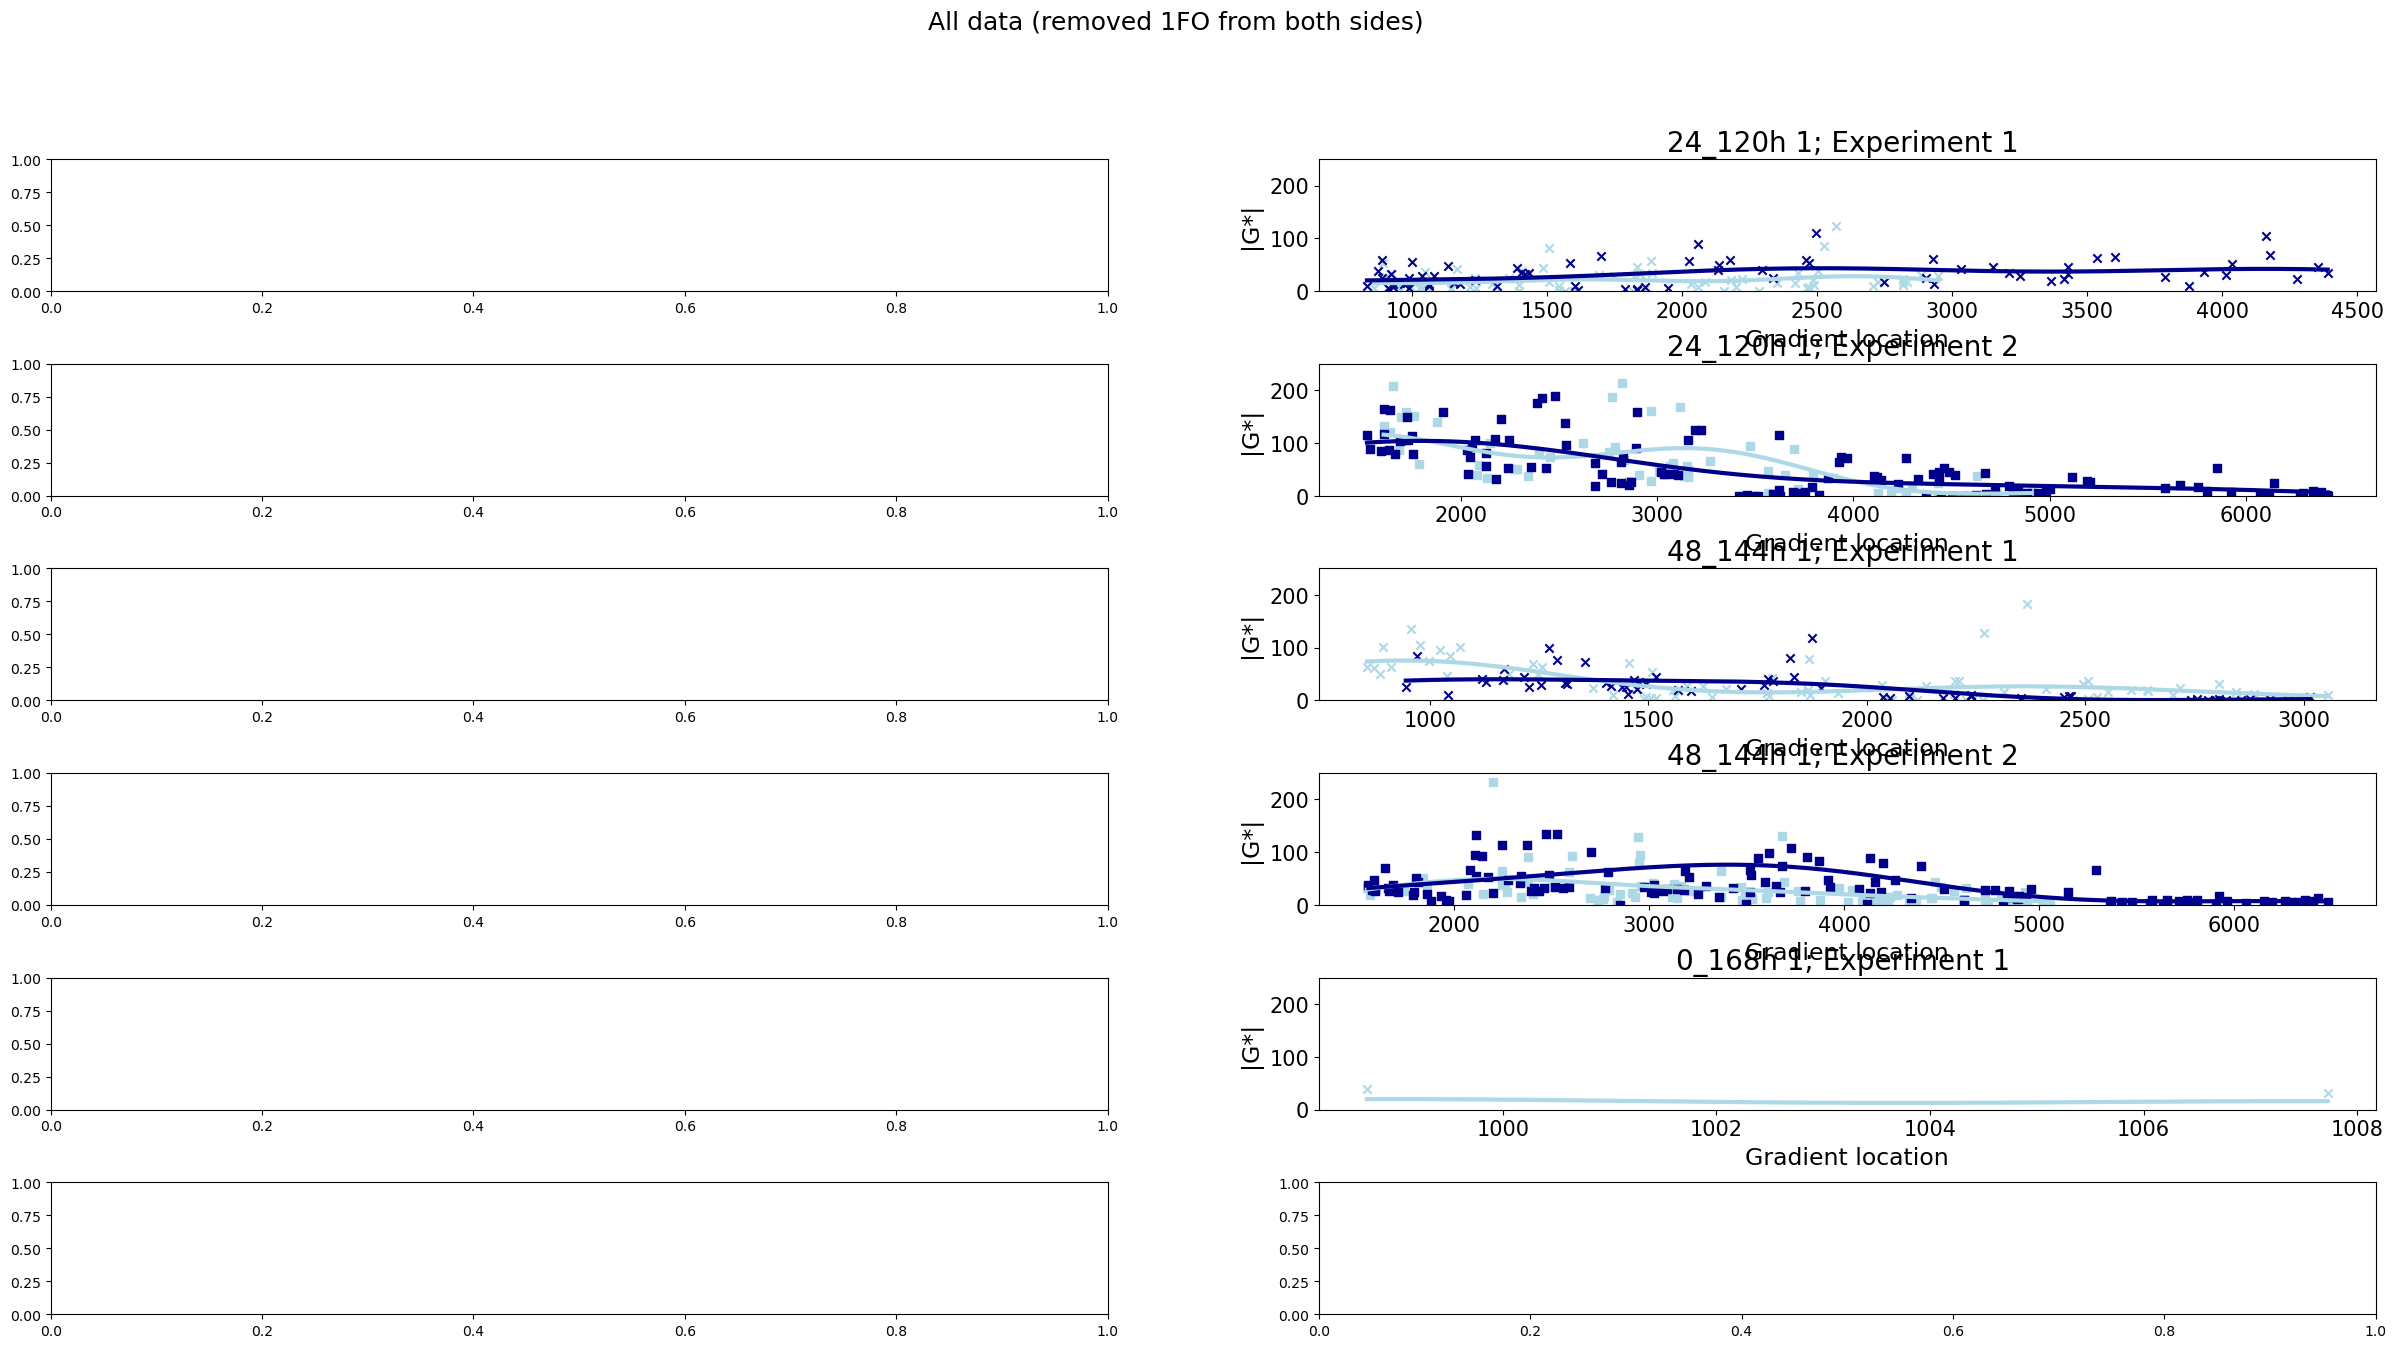

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("All data (removed 1FO from both sides)", fontsize=18)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            marker_type = markers[int(l)]
            row = (i*2)+(k)
            
            for m,o in enumerate(third['sample'].unique()):
                column = 0 if o=='MDAMB231' else 1
                fourth = third[third['sample']==o]
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row,column]                

                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    filtered_data = fourth[(fourth['gradient'] > fourth['gradient'].min()+800) & (fourth['gradient'] < fourth['gradient'].max()-800)]
                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(filtered_data['gradient'],filtered_data['G_abs'],ax,color_type,marker_type,1)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    filtered_data = fourth[(fourth['gradient_inverse'] > fourth['gradient_inverse'].min()+800) & (fourth['gradient_inverse'] < fourth['gradient_inverse'].max()-800)]

                    fitting_kernel(filtered_data['gradient_inverse'],filtered_data['G_abs'],ax,color_type,marker_type,1)
  
                ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
                ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o}; Experiment {k+1} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)
                
                ax.set_ylim (0,250) 
                #ax.set_xlim (0,5000)  
                

In [431]:
download['experiment'].unique()

array([0, 1], dtype=int64)

In [443]:
colors = sns.color_palette("muted",2)
print(colors)

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]


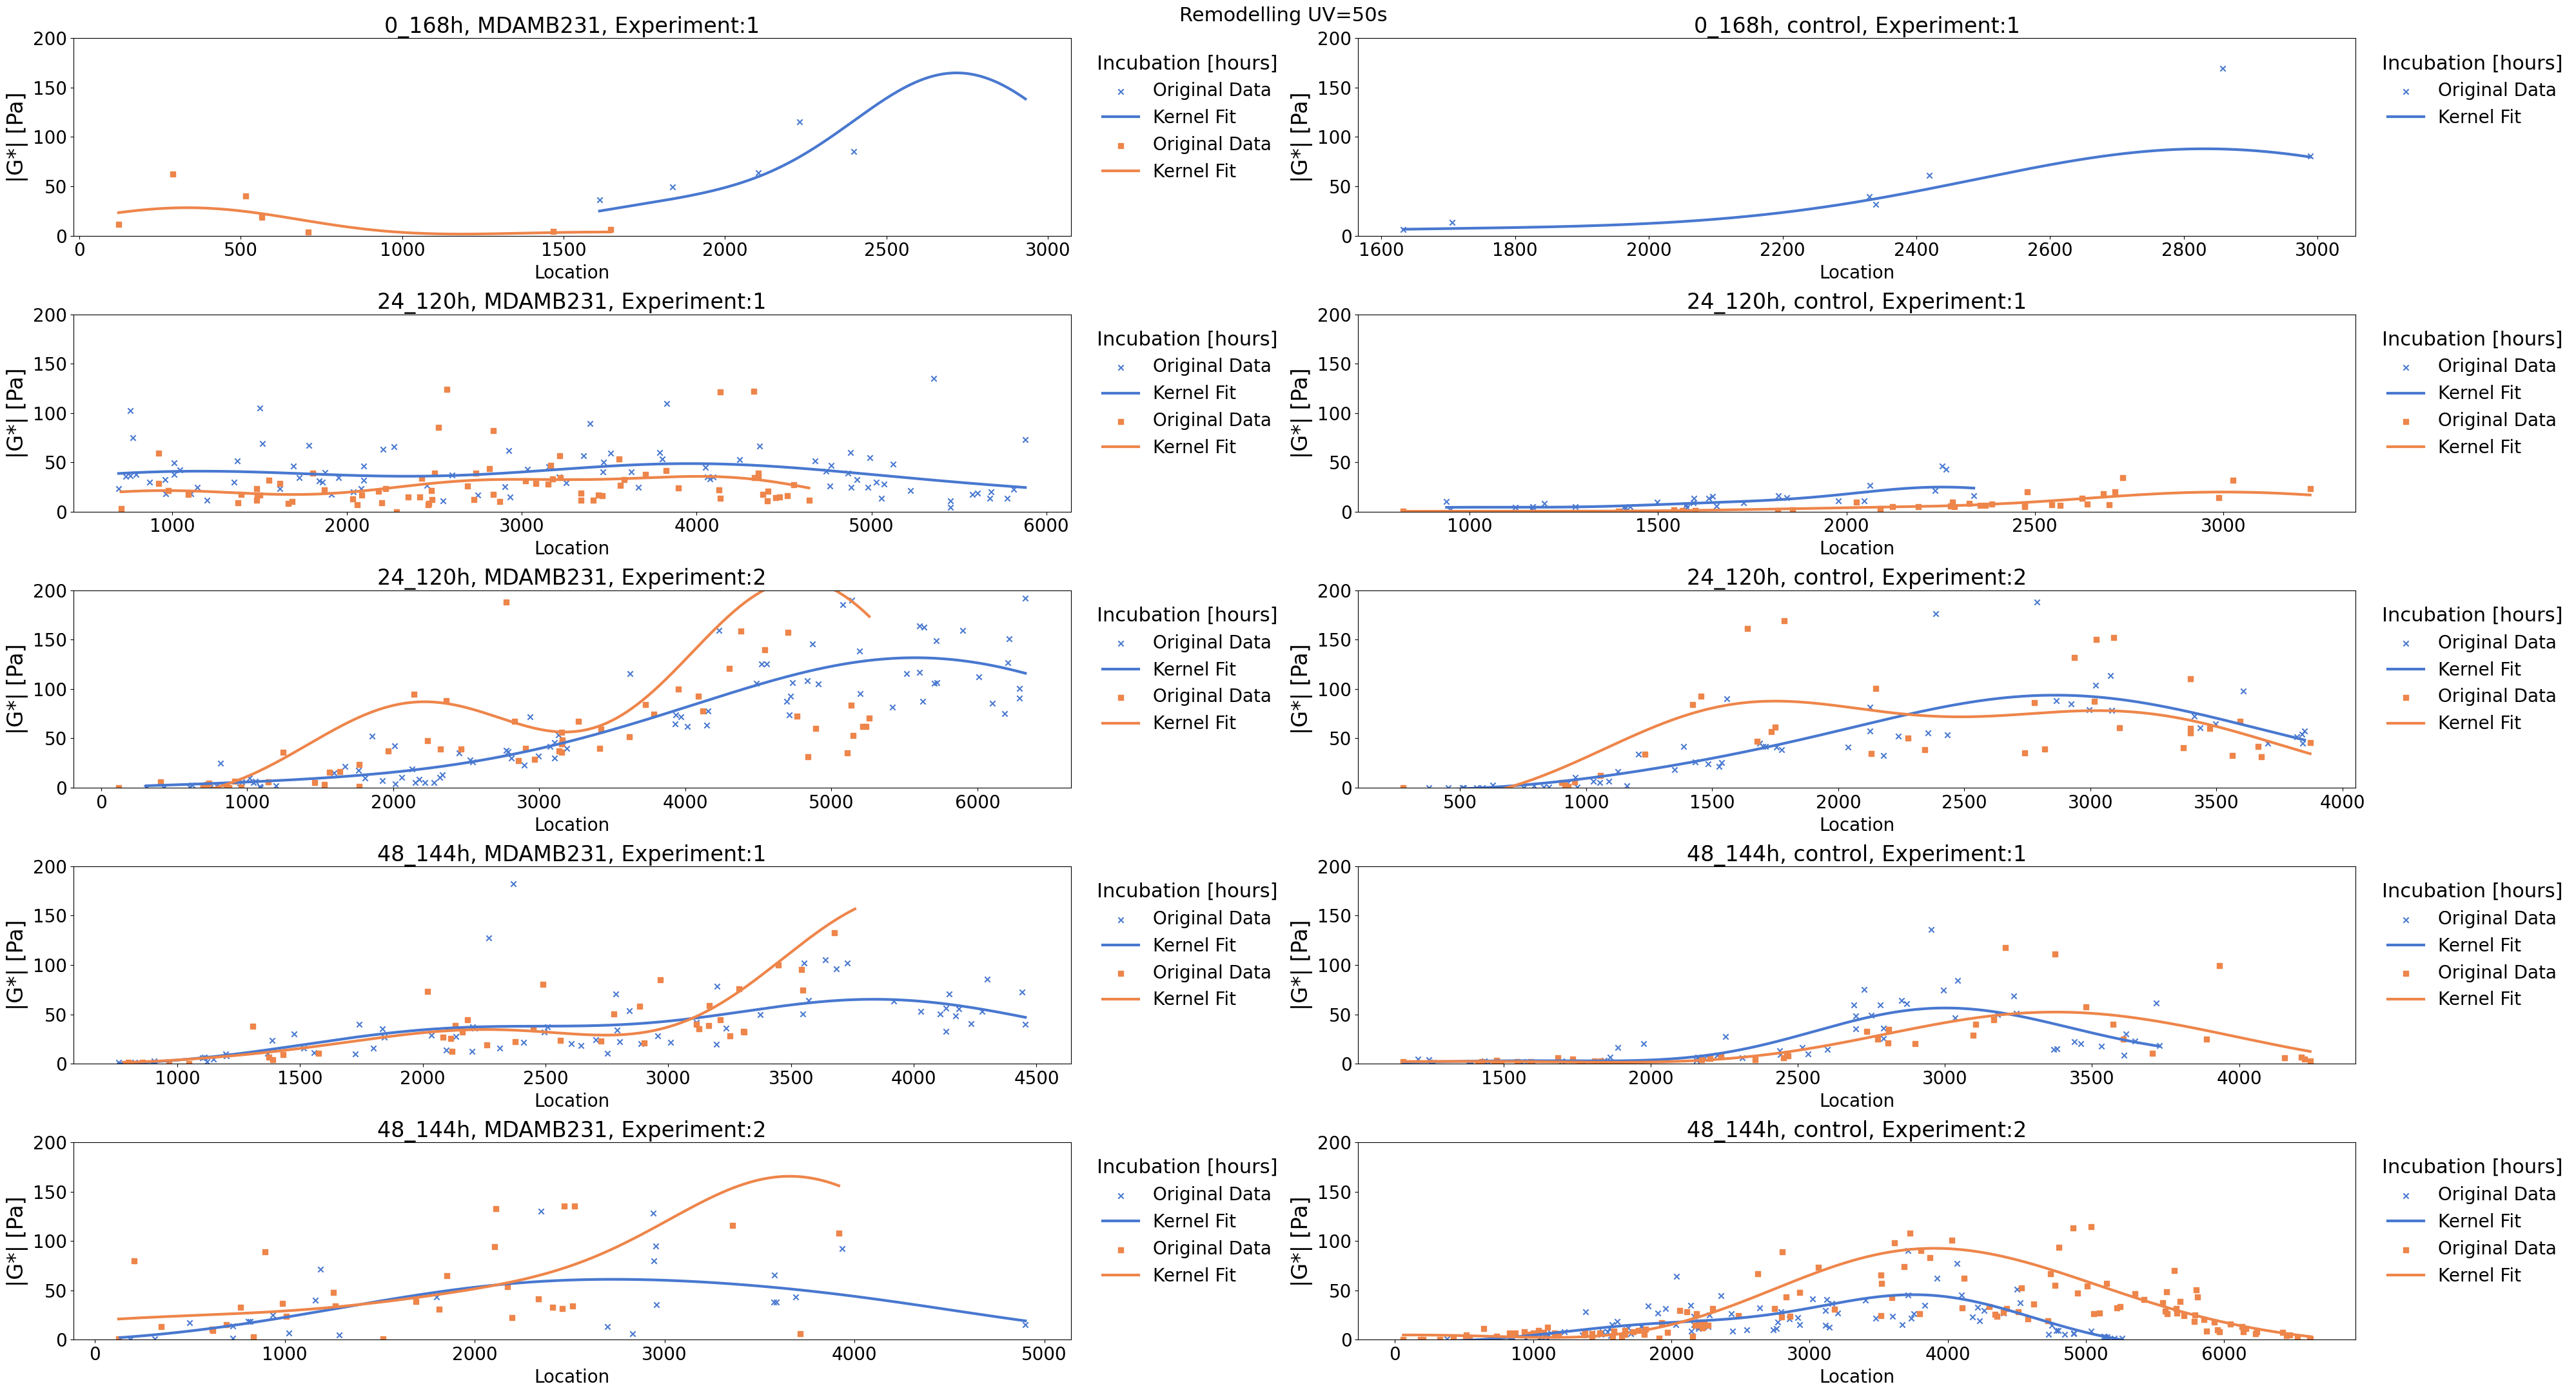

In [445]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['x', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['G_abs'], ax, 1, colors[j], markers[j])

    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 200)
    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.tight_layout()
plt.show()


Binned plot by locations

Time-series G*

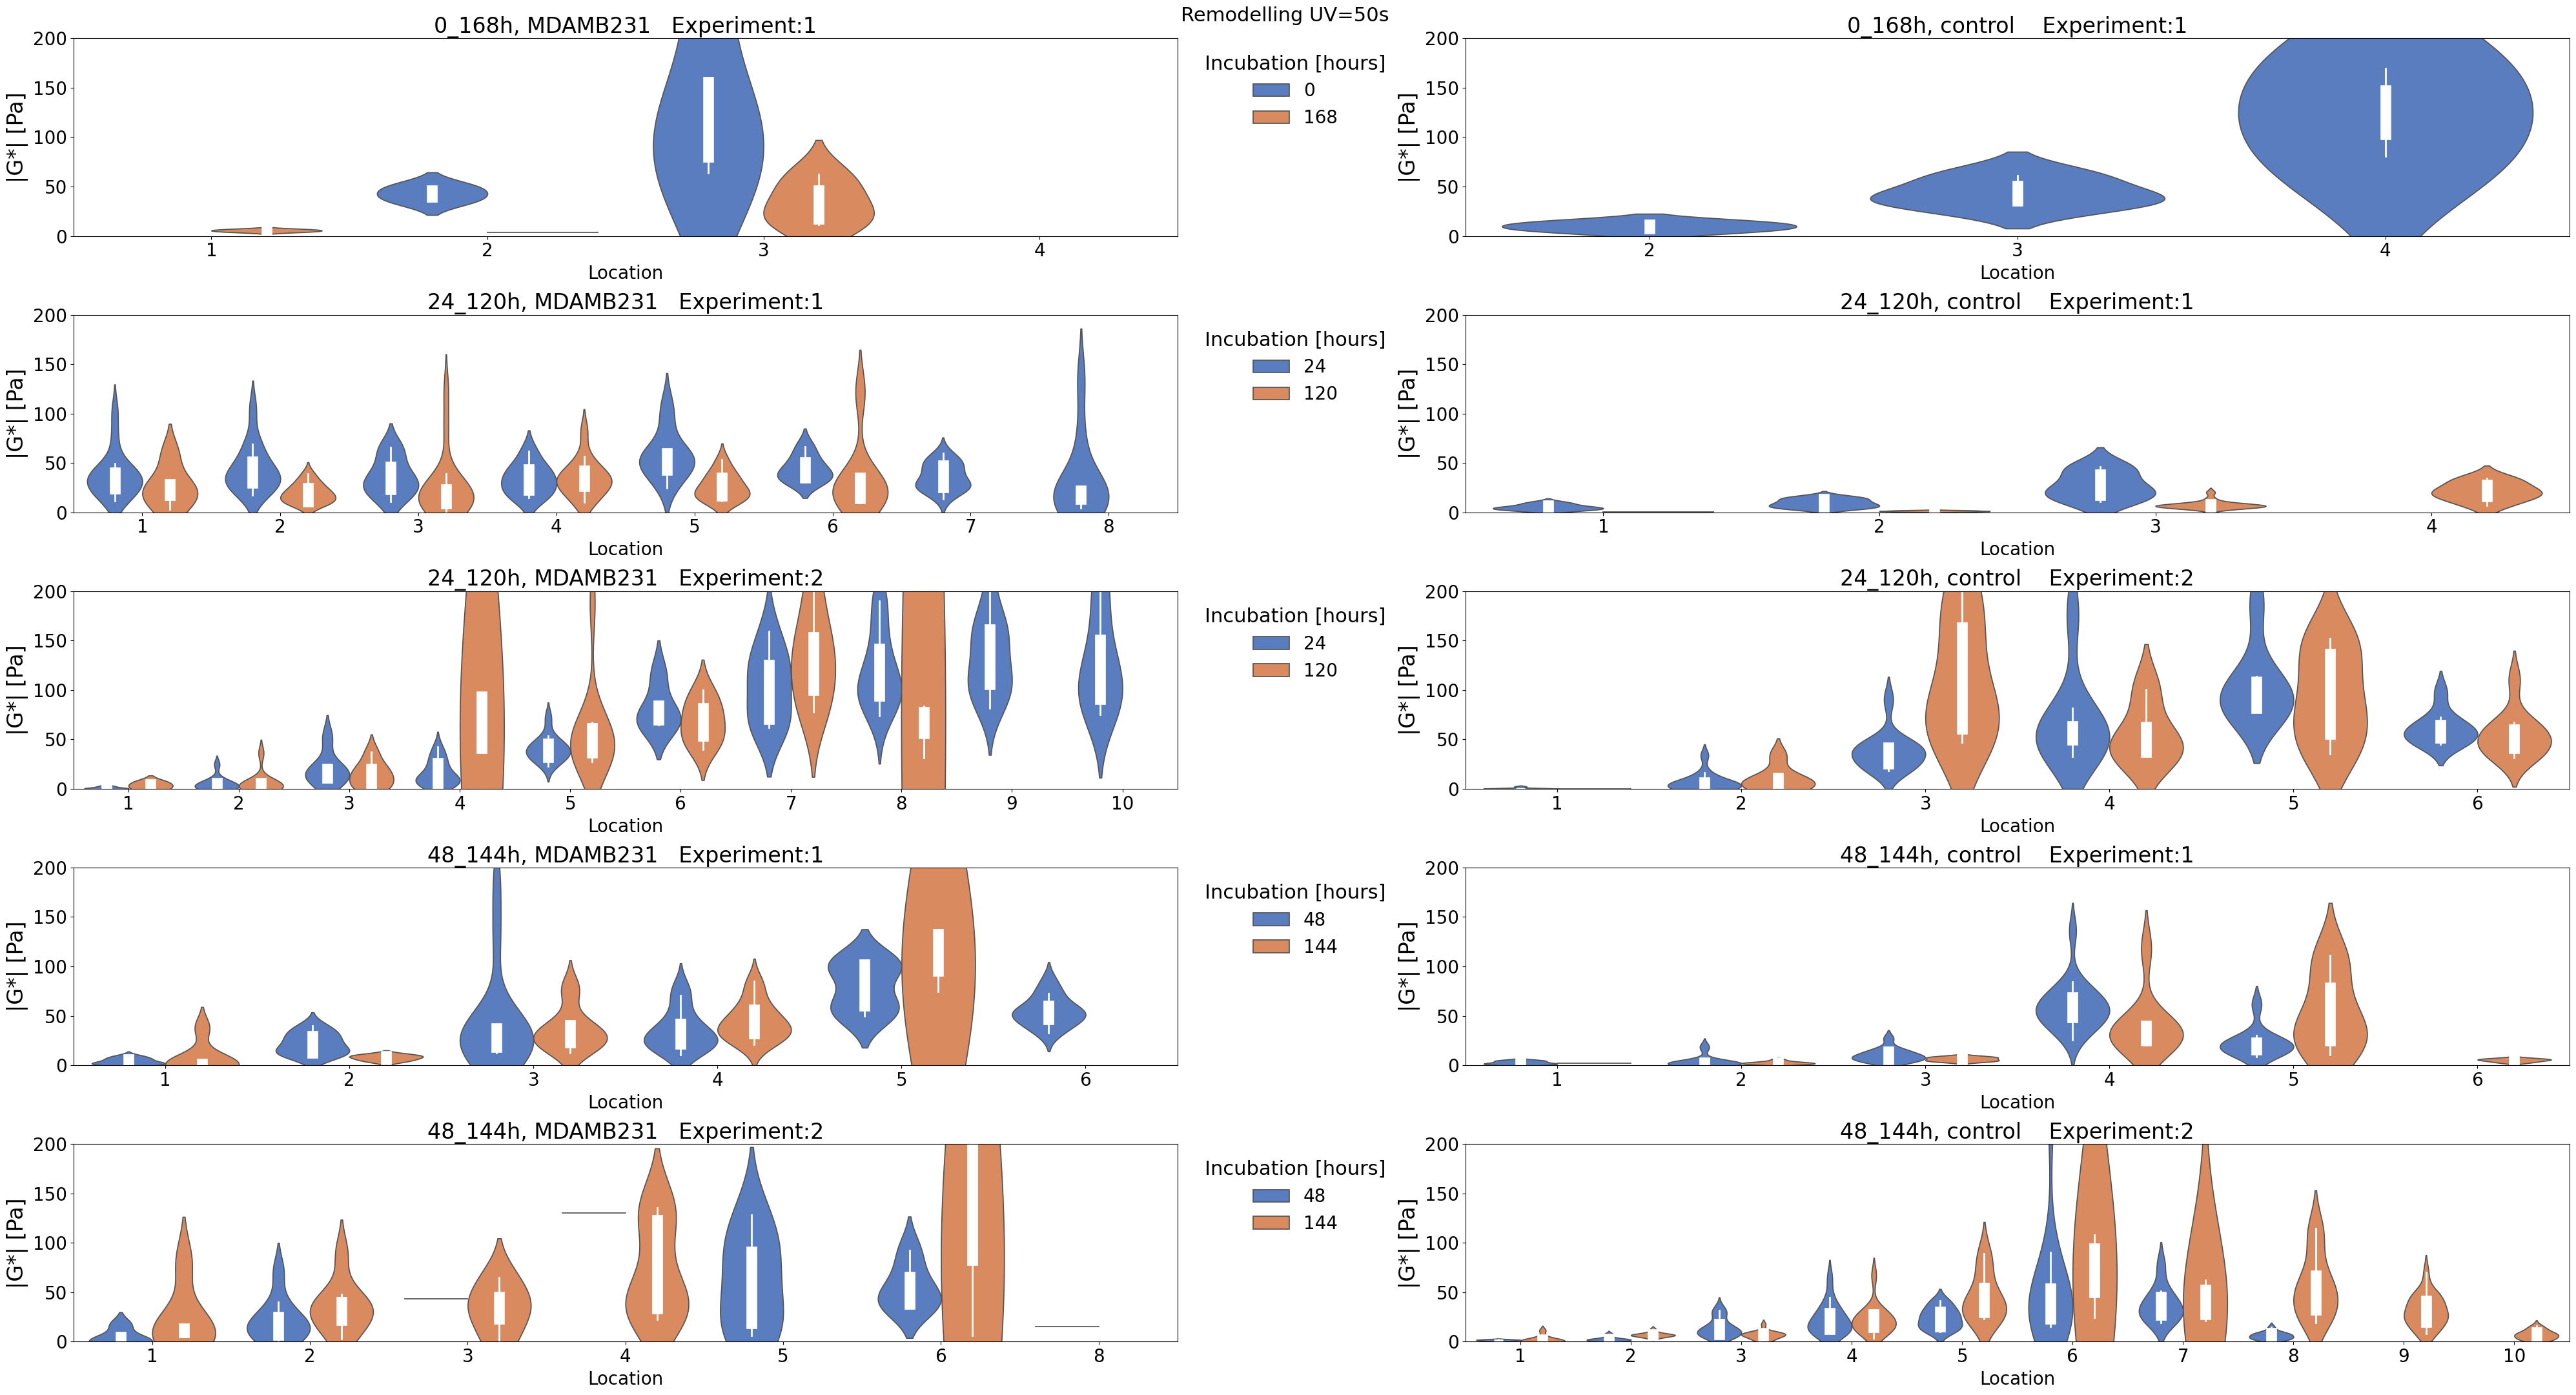

In [438]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the subplots
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ("muted",2)

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.violinplot(x=x_cell_data, y='G_abs', data=group_data_cell,
                    inner='box', width=0.8, density_norm='width', ax=ax, legend=True, hue='incubation',
                    inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 200) 
    legend = ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.violinplot(x=x_ctr_data, y='G_abs', data=group_data_control,
                   inner='box', width=0.8, density_norm='width', ax=ax1, legend=False, hue='incubation',
                   inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0, 200) 


for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Time-series G*

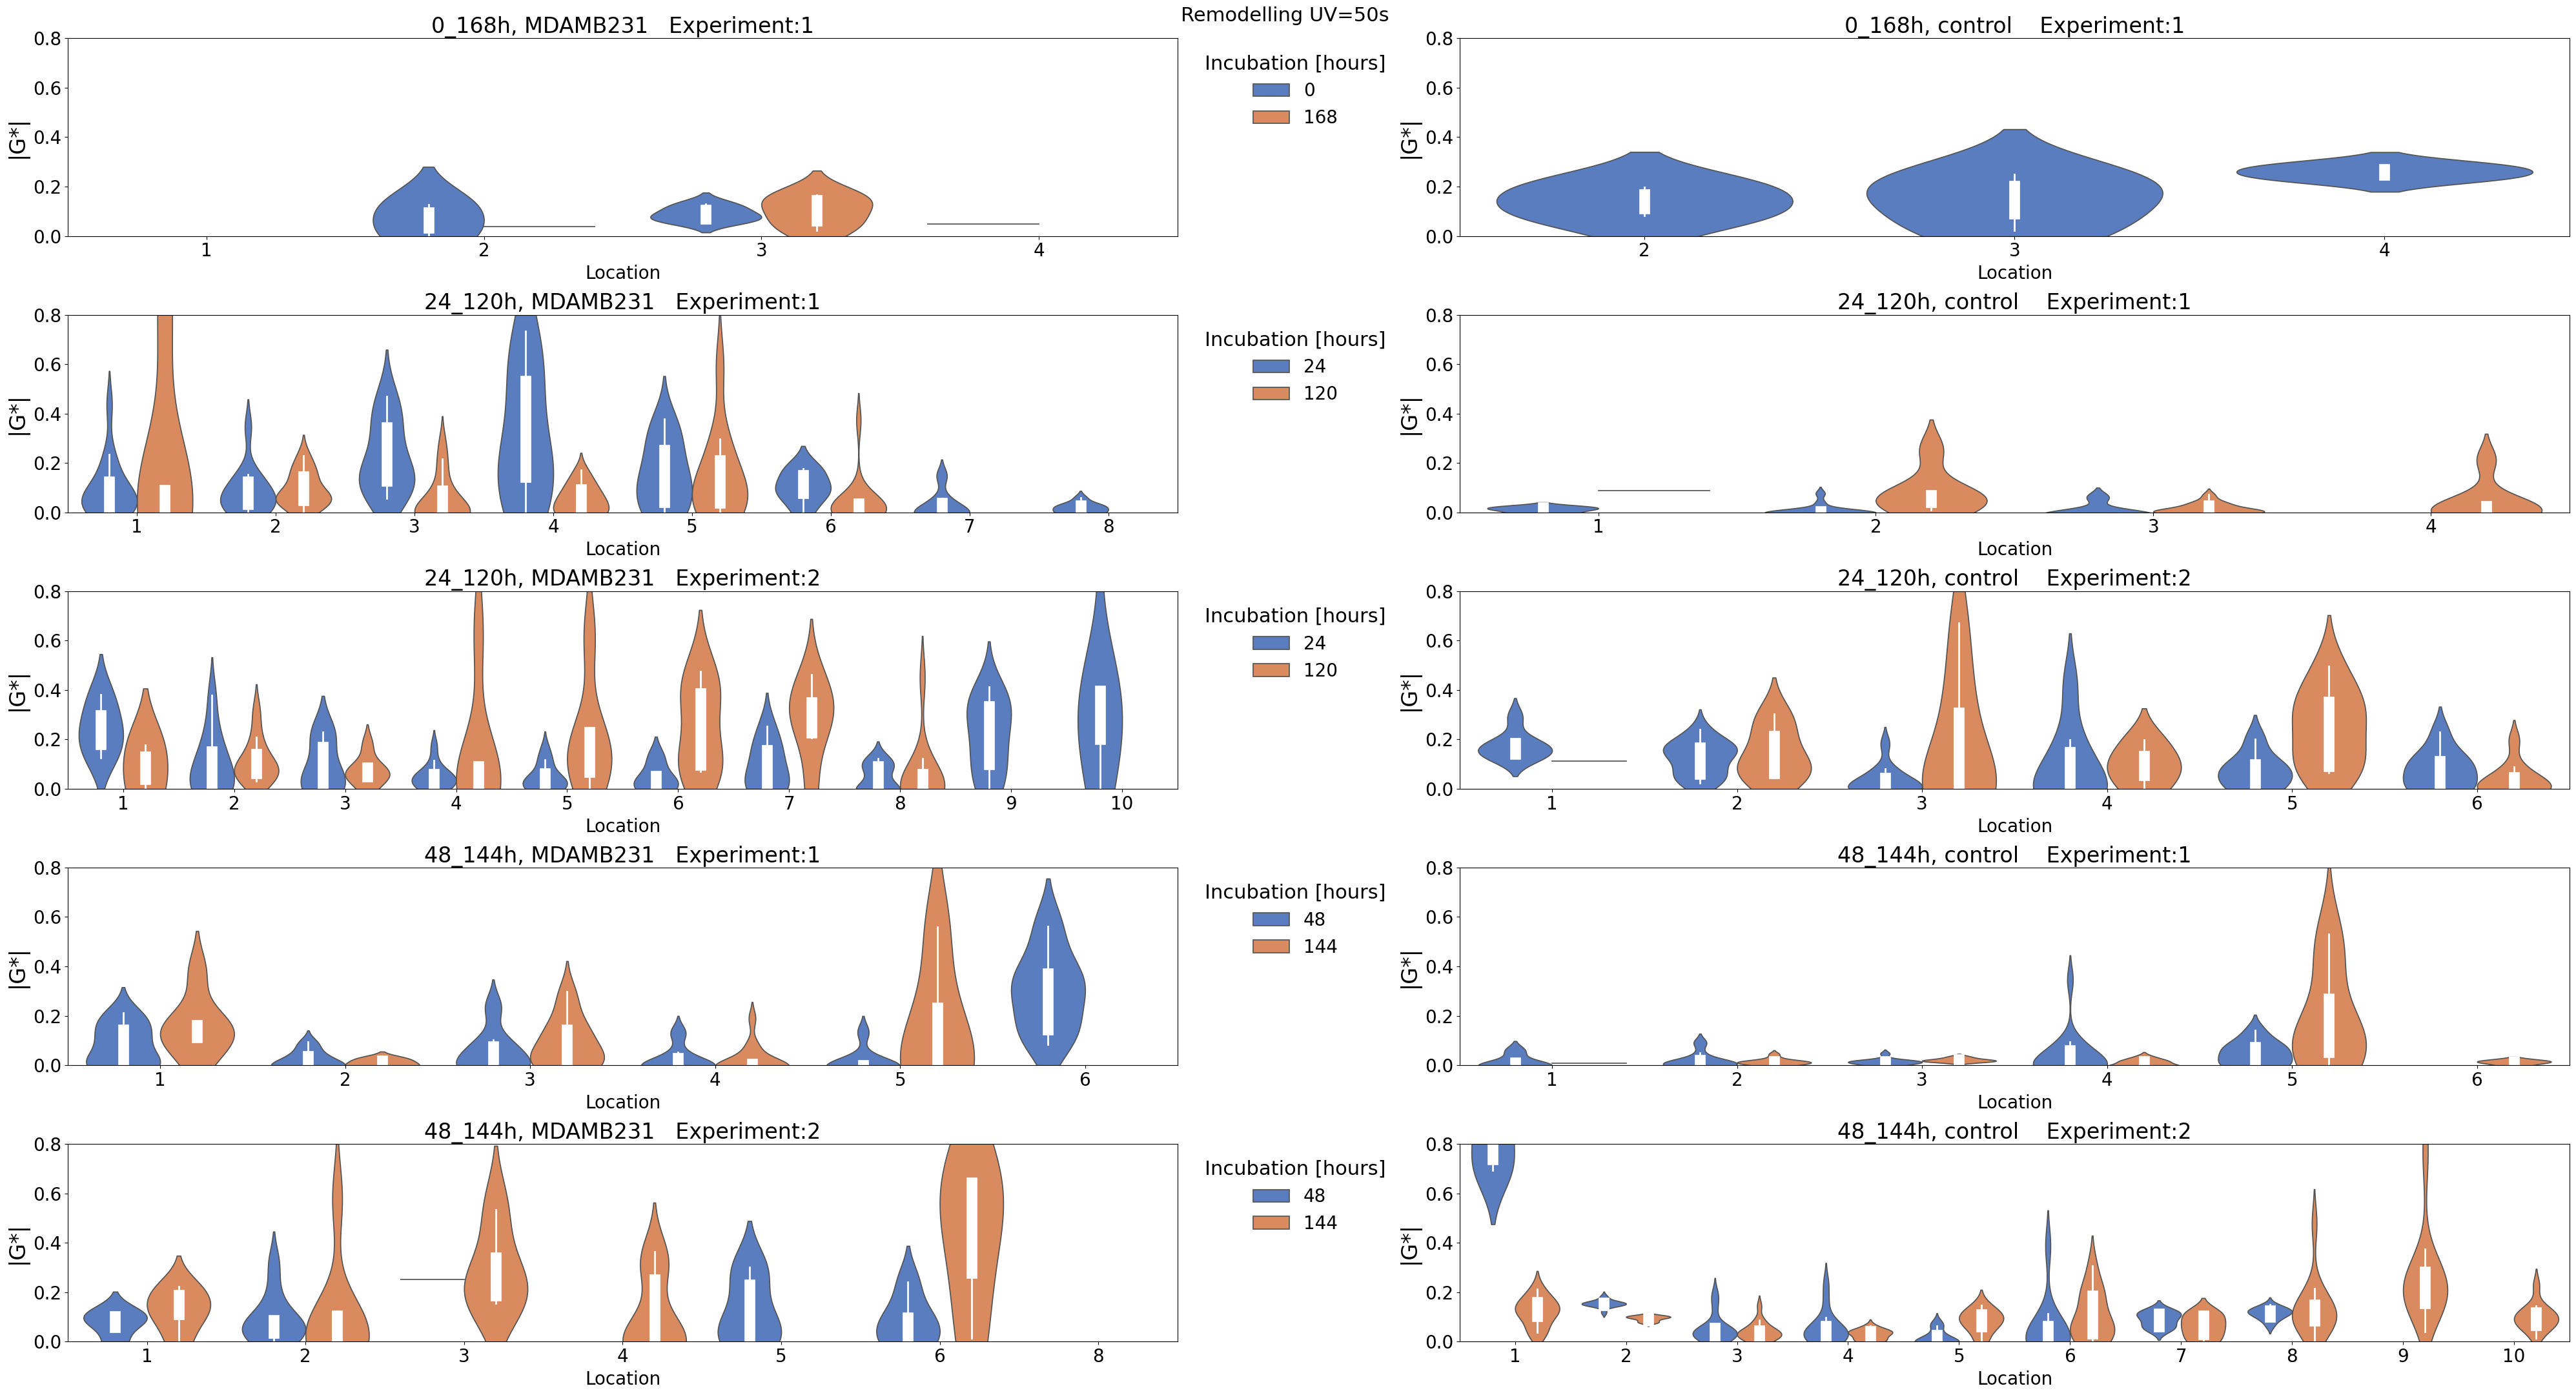

In [414]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the subplots
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ["lightblue", "darkblue"]

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.violinplot(x=x_cell_data, y='phi_(rad)', data=group_data_cell,
                    inner='box', width=0.8, density_norm='width', ax=ax, legend=True, hue='incubation',
                    inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("|G*|", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 0.8) 
    legend = ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.violinplot(x=x_ctr_data, y='phi_(rad)', data=group_data_control,
                   inner='box', width=0.8, density_norm='width', ax=ax1, legend=False, hue='incubation',
                   inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0, 0.8) 


for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [357]:
print(download['day'].unique())
print(download['holder'].unique())
print(download['cell/control'].unique())
print(download['experiment'].unique())

[241111 241125 241107 241121 241108 241122 241112 241126 240823 240830]
[1 2]
['MDAMB231' 'control']
[0 1]


C:\Users\srboval1\AppData\Local\Temp\ipykernel_12028\423531792.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_12028\423531792.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_12028\423531792.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_12028\423531792.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend()

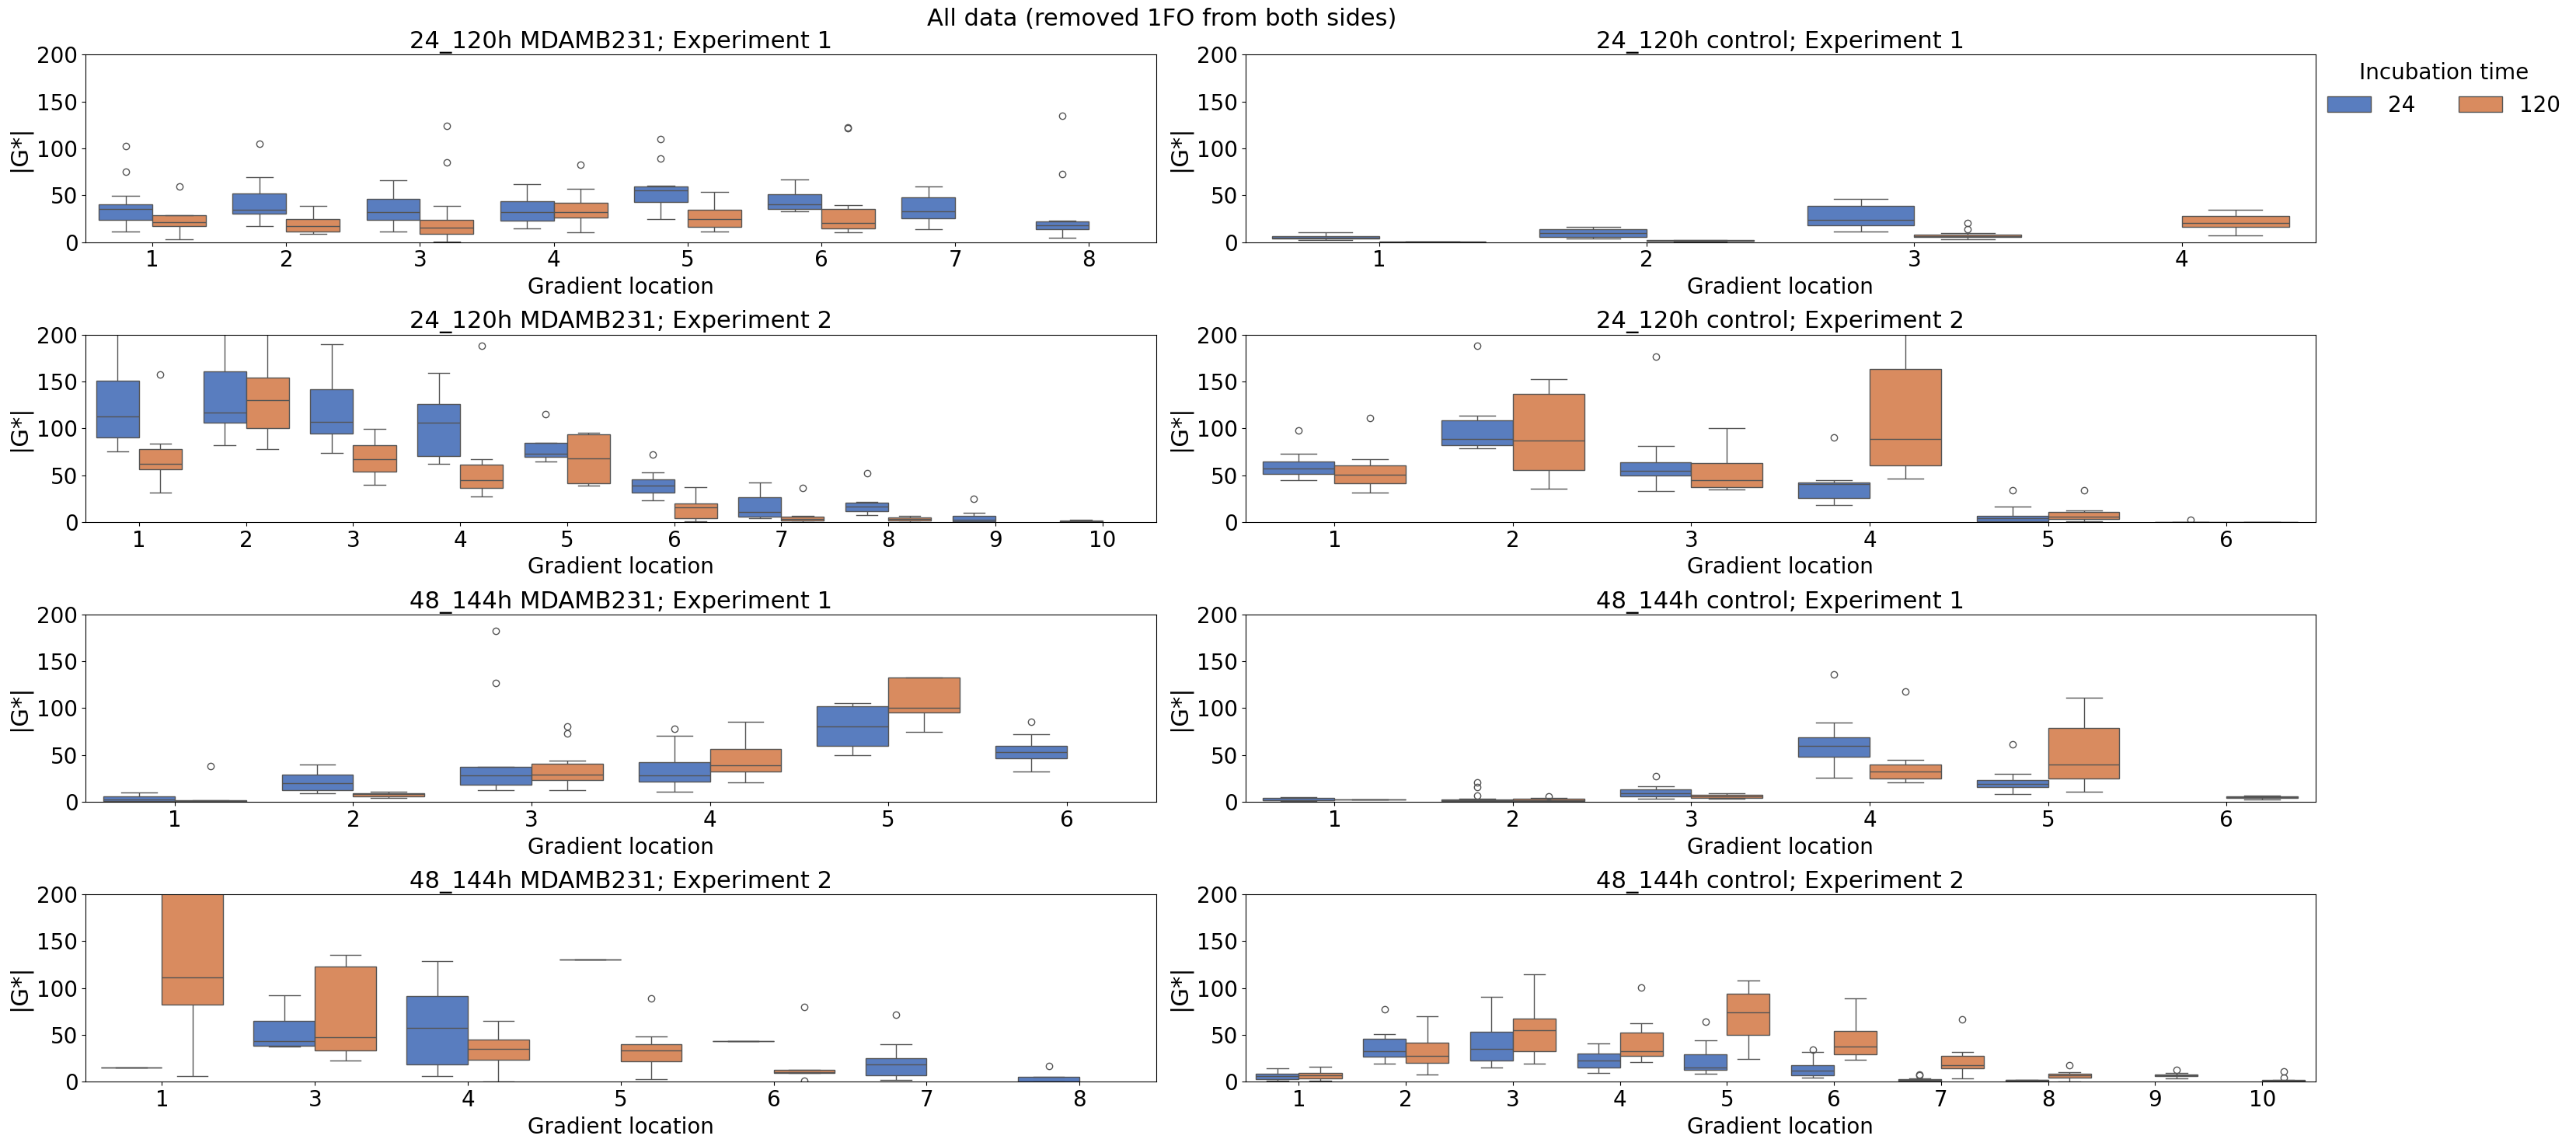

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.35, hspace=0.65, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("All data (removed 1FO from both sides)", fontsize=22)

markers = ['x', 's']
colors = ["lightblue", "darkblue"]

# Loop through each incubation set
for i, j in enumerate(download['incubation_set'].unique()):
    second = download[download['incubation_set'] == j]

    # Loop through each experiment
    for k, l in enumerate(second['experiment'].unique()):
        third = second[second['experiment'] == l]
        marker_type = markers[int(l)]
        row = (i * 2) + k  # Determine the correct row in the subplot grid

        # Loop through each sample
        for m, o in enumerate(third['sample'].unique()):
            column = 0 if o == 'MDAMB231' else 1
            fourth = third[third['sample'] == o]
            date_value = str(fourth['day'].unique()[0])
            ax = axs[row, column]  # Access the subplot by row and column

            # Check for the gradient direction and filter data accordingly
            if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                filtered_data = fourth[
                    (fourth['gradient'] > fourth['gradient'].min() + 800) & 
                    (fourth['gradient'] < fourth['gradient'].max() - 800)
                ]
                if row == 0 and m == 0:  
                    sns.boxplot(x='location', y='G_abs', data=fourth, ax=ax, hue='incubation', palette="muted",legend=True)
                else:
                    sns.boxplot(x='location', y='G_abs', data=fourth, ax=ax, hue='incubation', palette="muted",legend=False)

            else:
                filtered_data = fourth[
                    (fourth['gradient_inverse'] > fourth['gradient_inverse'].min() + 800) & 
                    (fourth['gradient_inverse'] < fourth['gradient_inverse'].max() - 800)
                ]
                if row == 0 and m == 0: 
                    sns.boxplot(x='location', y='G_abs', data=fourth, ax=ax, hue='incubation', palette="muted",legend=True)

                else:
                    sns.boxplot(x='location', y='G_abs', data=fourth, ax=ax, hue='incubation', palette="muted",legend=False)


            # Set labels, title, and styling for each subplot
            ax.set_xlabel("Gradient location", fontsize=20, labelpad=5)
            ax.set_ylabel("|G*|", fontsize=22, labelpad=5)
            ax.set_title(f"{j}h {o}; Experiment {k + 1}", fontsize=22)
            ax.tick_params(axis='both', labelsize=20)
            # Set the y-axis limit and optionally the x-axis limit
            ax.legend().remove()
            ax.set_ylim(0, 200)
            # ax.set_xlim(0, 5000)  # Uncomment and adjust if needed

# Add the legend only once after all the plots
fig.legend(title="Incubation time", loc='upper center', title_fontsize=20, fontsize=20, ncol=2, bbox_to_anchor=(1.05, 0.95), frameon=False)

# Show the plot
plt.tight_layout()
plt.show()





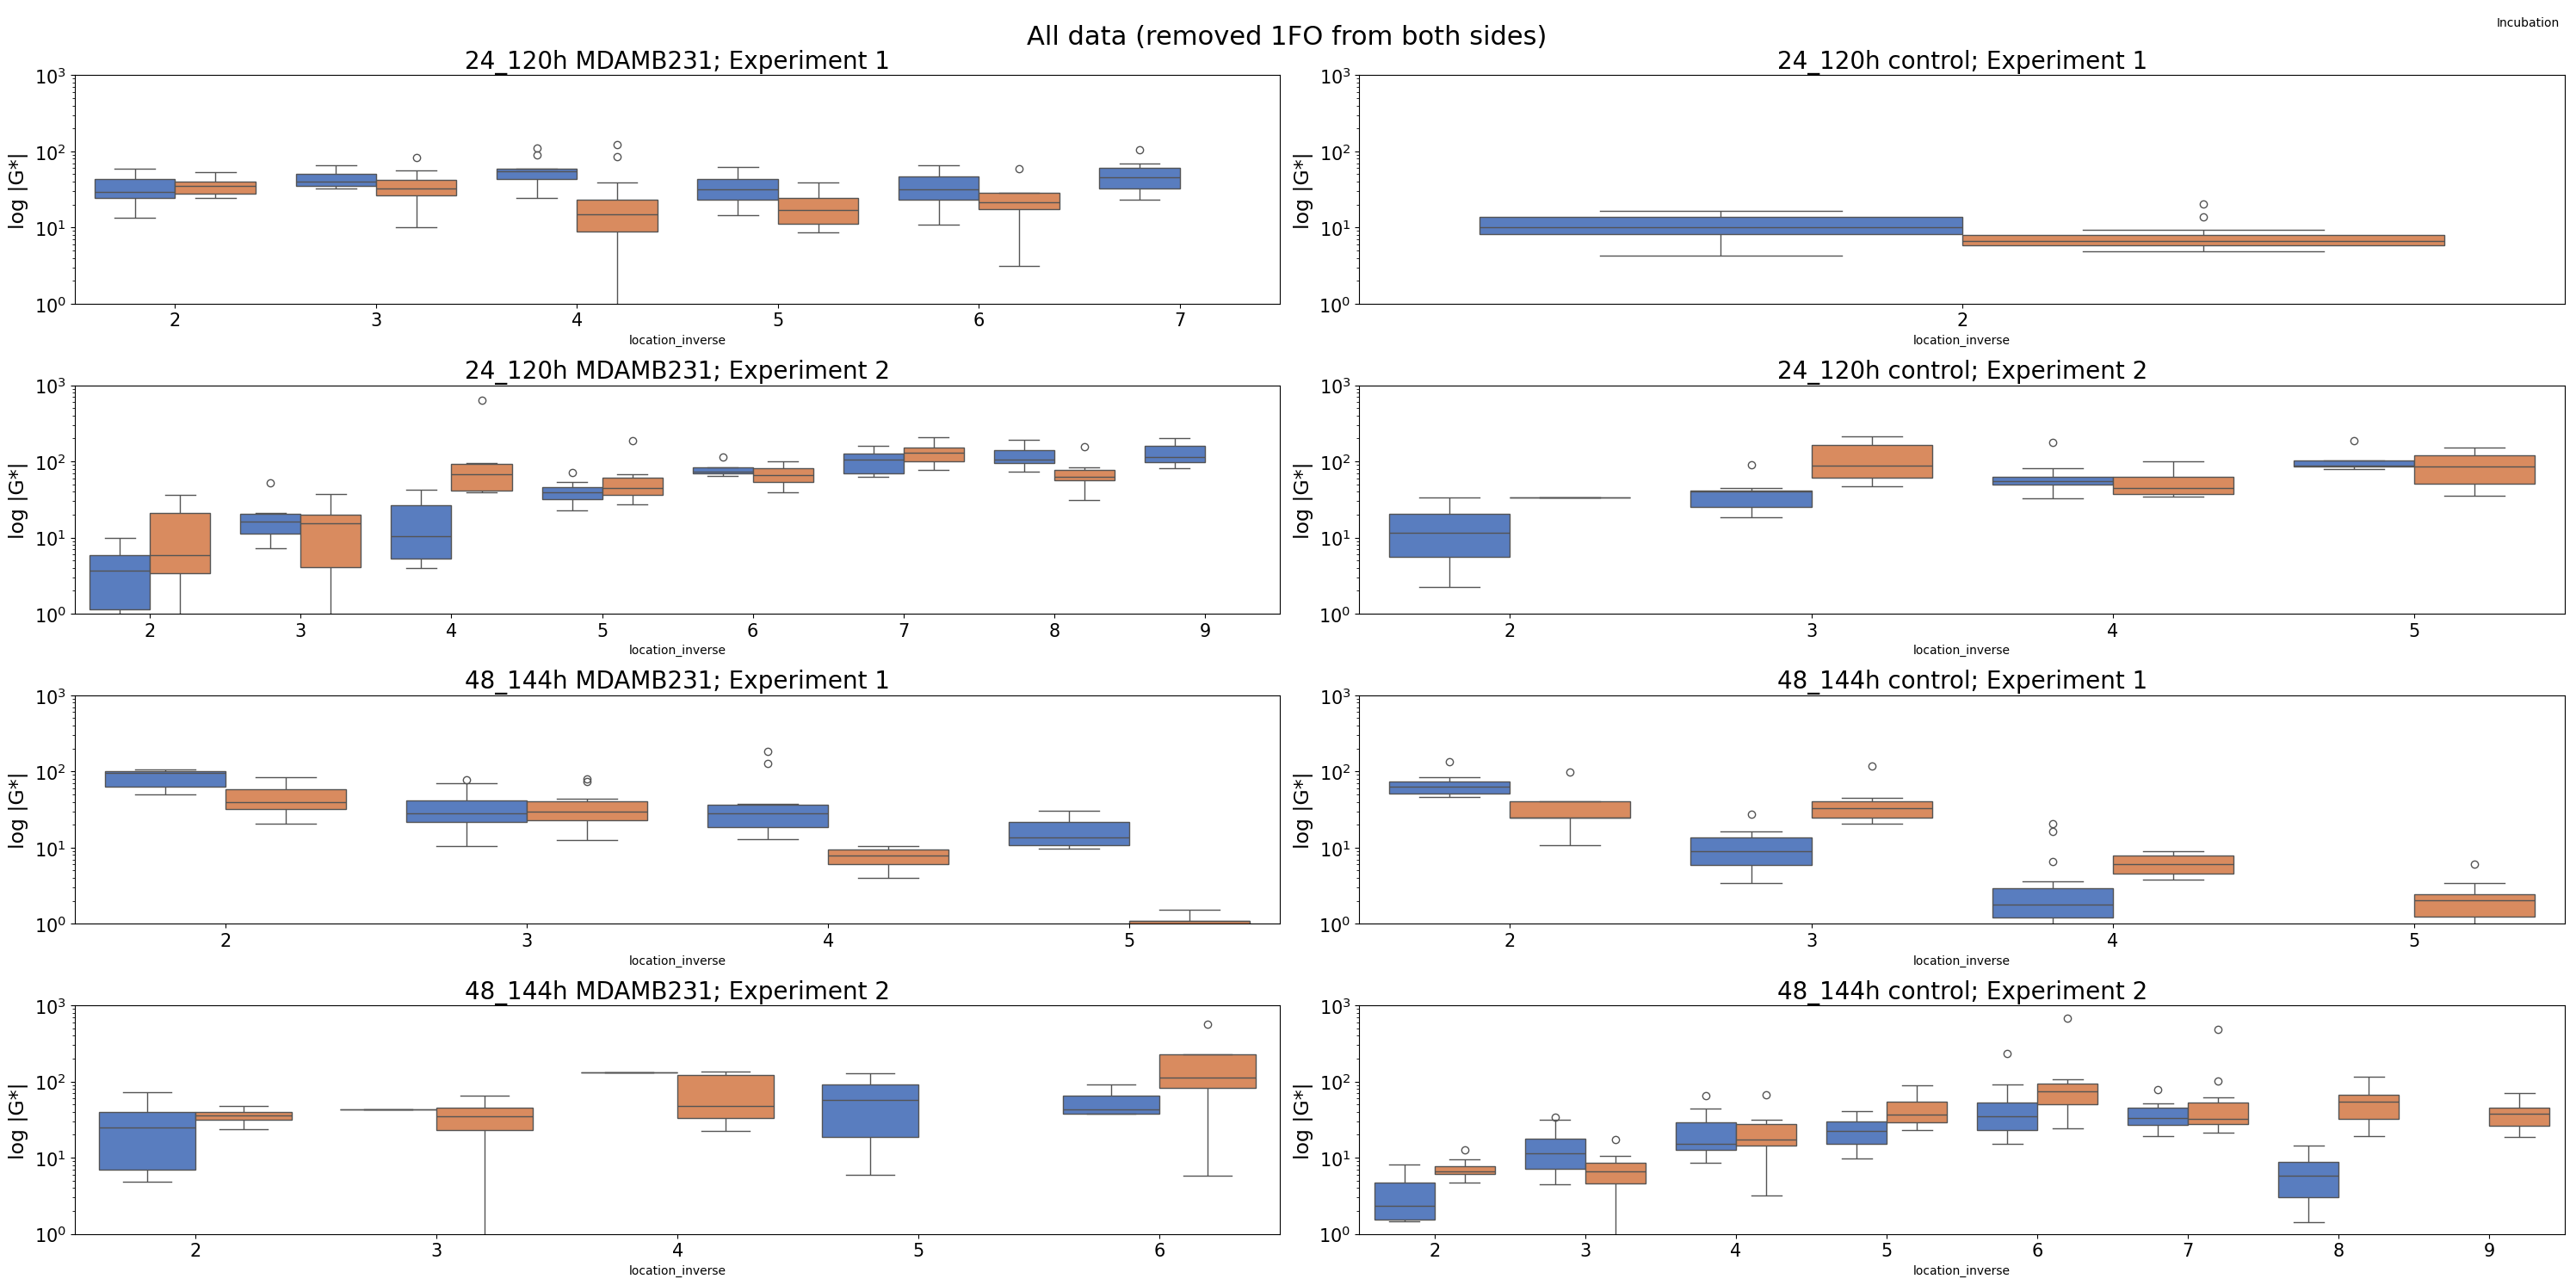

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("All data (removed 1FO from both sides)", fontsize=22)

markers = ['x', 's']
colors = ["lightblue", "darkblue"]
handles, labels = [], []


# Loop through each incubation set
for i, j in enumerate(download['incubation_set'].unique()):
    second = download[download['incubation_set'] == j]

    # Loop through each incubation time within the incubation set
    # for nn, n in enumerate(first['incubation'].unique()):
    #     second = first[first['incubation'] == n]
    #     color_type = colors[int(nn)]

    # Loop through each experiment
    for k, l in enumerate(second['experiment'].unique()):
        third = second[second['experiment'] == l]
        marker_type = markers[int(l)]
        row = (i * 2) + k  # Determine the correct row in the subplot grid

        # Loop through each sample
        for m, o in enumerate(third['sample'].unique()):
            column = 0 if o == 'MDAMB231' else 1
            fourth = third[third['sample'] == o]
            date_value = str(fourth['day'].unique()[0])
            ax = axs[row, column]  

            # Check for the gradient direction and filter data accordingly
            if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                filtered_data = fourth[
                    (fourth['gradient'] > fourth['gradient'].min() + 800) & 
                    (fourth['gradient'] < fourth['gradient'].max() - 800)
                ]
                box=sns.boxplot(x='location', y='G_abs', data=filtered_data, ax=ax, hue='incubation', palette="muted",legend=False)       
            else:
                filtered_data = fourth[
                    (fourth['gradient_inverse'] > fourth['gradient_inverse'].min() + 800) & 
                    (fourth['gradient_inverse'] < fourth['gradient_inverse'].max() - 800)
                ]
                box=sns.boxplot(x='location_inverse', y='G_abs', data=filtered_data, ax=ax, hue='incubation', palette="muted",legend=False)
            for handle, label in zip(*box.get_legend_handles_labels()):
                handles.append(handle)
                labels.append(label)
            ax.set_ylabel("log |G*|", fontsize=17, labelpad=5)
            ax.set_title(f"{j}h {o}; Experiment {k + 1}", fontsize=20)
            ax.tick_params(axis='both', labelsize=15)
            #ax.set_ylim(0, 200)
            ax.set_yscale('log')
            ax.set_ylim(1, 1000)


fig.legend(handles, labels, fontsize=16, title="Incubation", ncol=2, frameon=False)

plt.tight_layout()
plt.show()


Plotting CLOSBY

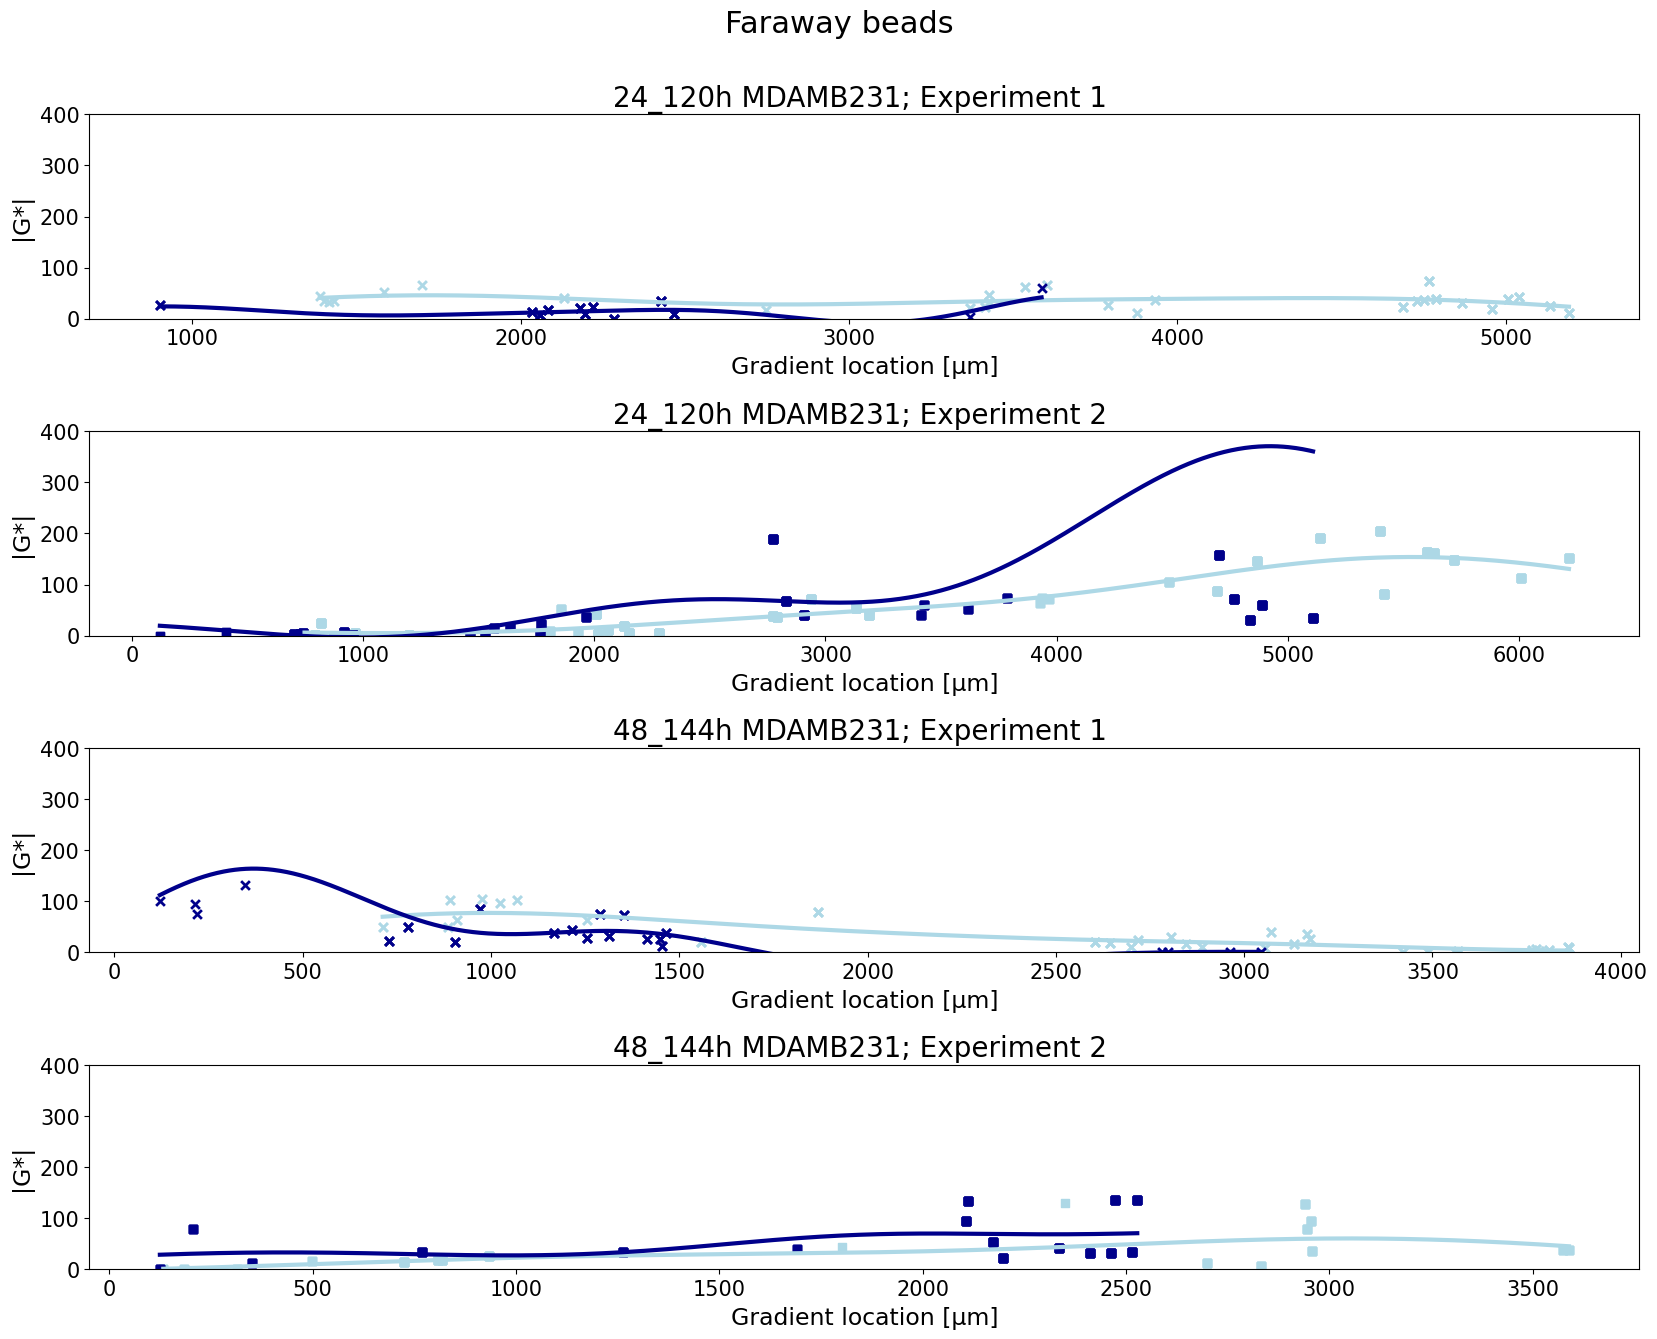

In [199]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("Faraway beads", fontsize=22, y=0.95)

markers=['x','s']

colors = ["lightblue","darkblue"]
first = []

for i,j in enumerate(final_faraway['incubation_set'].unique()):
    first = final_faraway[final_faraway['incubation_set']==j]
    
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)
        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            
            marker_type = markers[int(l)]
            row = (i*2)+(k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                fourth = third[third['sample']==o]
                #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row]
                #GLS_g(dfffff,ax,color)

                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,1)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type,1)
  
                ax.set_xlabel("Gradient location [µm]", fontsize= 17,labelpad=5)
                ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o}; Experiment {k+1} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)
                
                ax.set_ylim (0,400) 
                #ax.set_xlim (0,5000)  
  
                


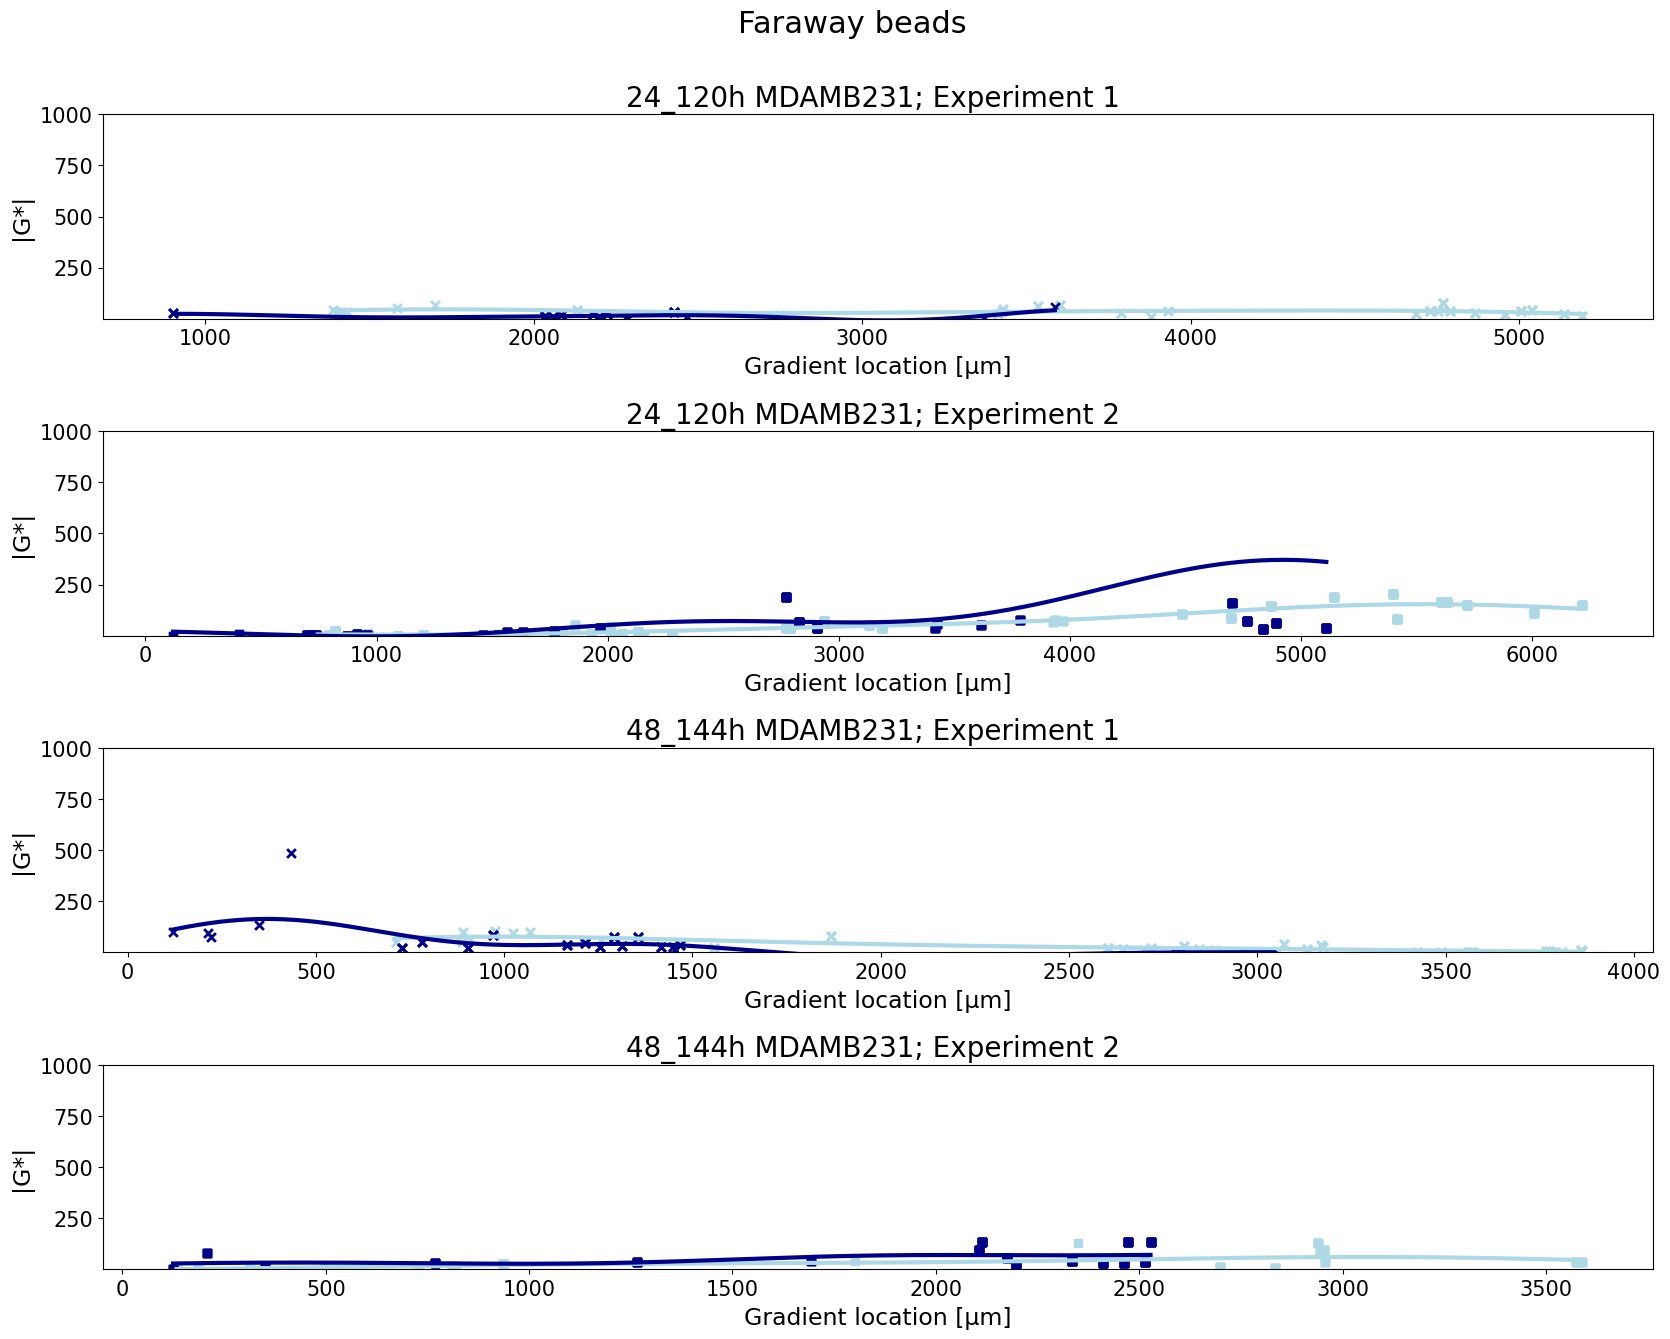

In [214]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("Faraway beads", fontsize=22, y=0.95)

markers=['x','s']

colors = ["lightblue","darkblue"]
first = []

for i,j in enumerate(final_faraway['incubation_set'].unique()):
    first = final_faraway[final_faraway['incubation_set']==j]
    
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)
        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            
            marker_type = markers[int(l)]
            row = (i*2)+(k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                fourth = third[third['sample']==o]
                #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row]
                #GLS_g(dfffff,ax,color)

                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    filtered_data = fourth[(fourth['gradient'] > fourth['gradient'].min()+800) & (fourth['gradient'] < fourth['gradient'].max()-800)]

                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,1)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    filtered_data = fourth[(fourth['gradient_inverse'] > fourth['gradient_inverse'].min()+800) & (fourth['gradient_inverse'] < fourth['gradient_inverse'].max()-800)]

                    fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type,1)
  
                ax.set_xlabel("Gradient location [µm]", fontsize= 17,labelpad=5)
                ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o}; Experiment {k+1} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)
                #ax.set_yscale('log')
                #ax.set_xscale('log')

                ax.set_ylim (0.0001,1000) 
                #ax.set_xlim (0,5000)  
  
                


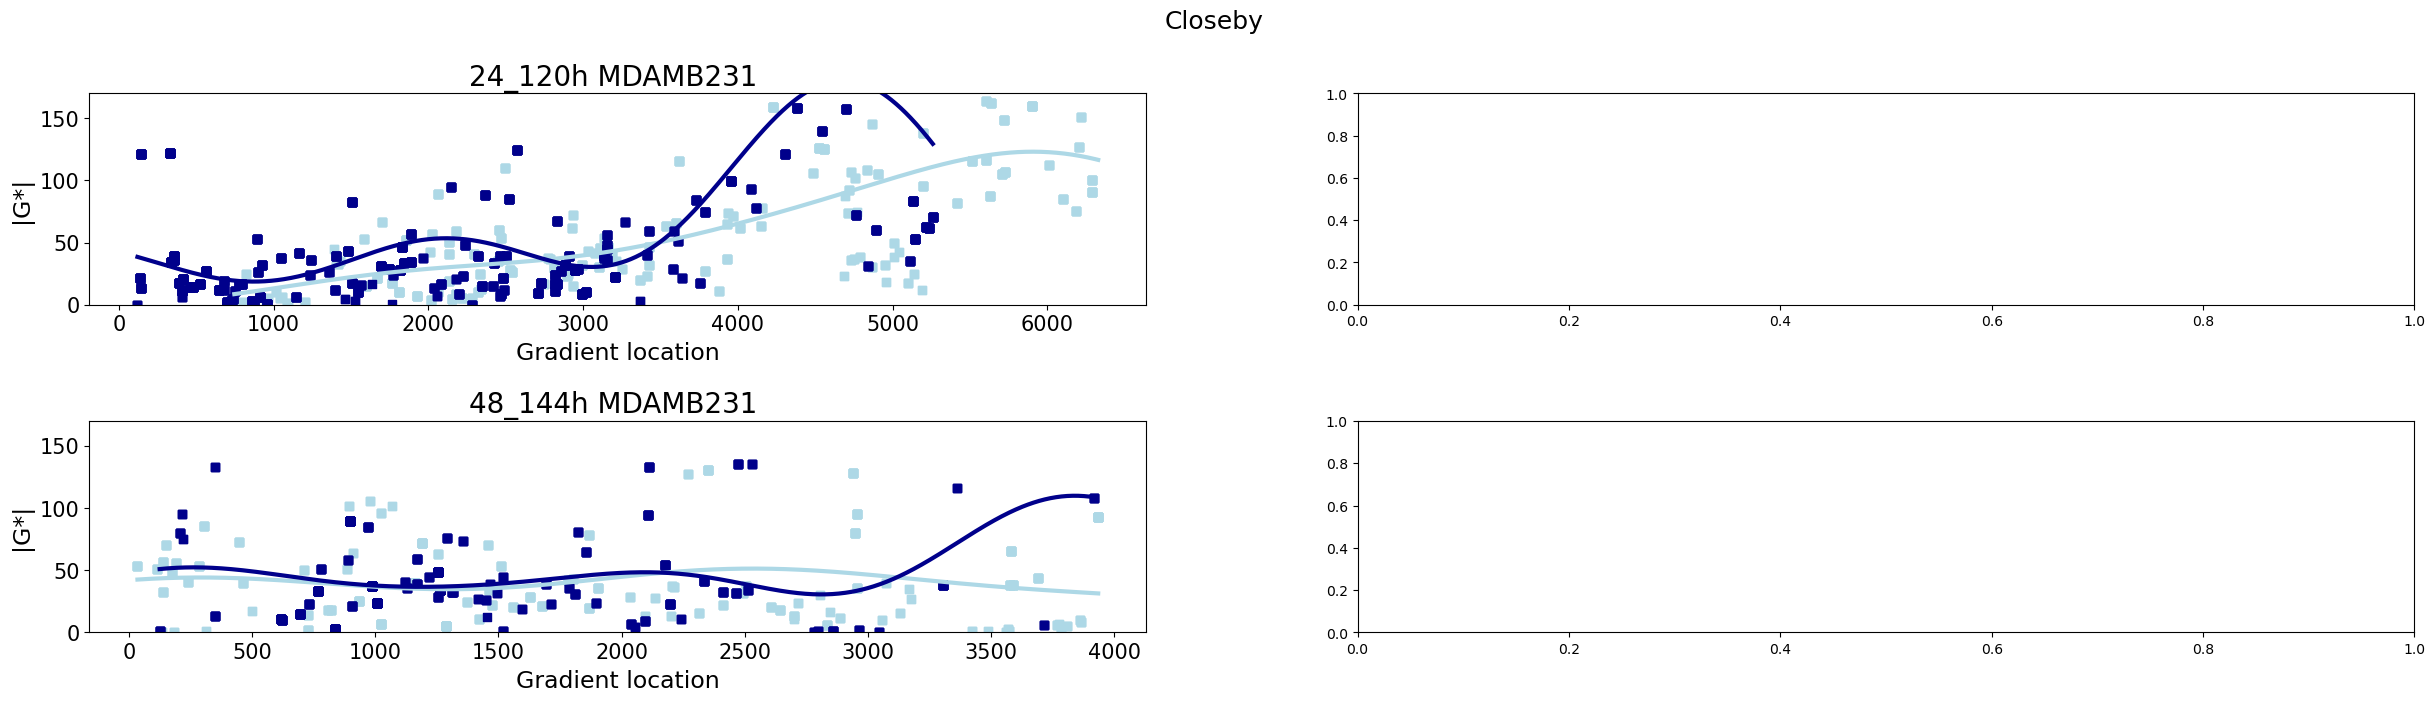

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(30, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("Closeby", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download_closeby['incubation_set'].unique()):
    first = download_closeby[download_closeby['incubation_set']==j]
    row = i
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        
        # for k,l in enumerate(second['experiment'].unique()):
        #     third = second[second['experiment']==l]
        #     marker_type = markers[l]
        #     row = (i*2)+(k)
        #     #print(l, marker_type)
        
        for m,o in enumerate(second['sample'].unique()):
            column = 0 if o=='MDAMB231' else 1
            fourth = second[second['sample']==o]
            #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
            date_value = str(fourth['day'].unique()[0])
            ax = axs[row,column]
            #GLS_g(dfffff,ax,color)

            if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
                #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,10)
                
            else:
                #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type,10)

            ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
            ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
            ax.set_title(f"{j}h {o} ", fontsize = 20)
            ax.tick_params(axis='both', labelsize=15)
            
            ax.set_ylim (0,170) 
            #ax.set_xlim (0,5000)  
  
                

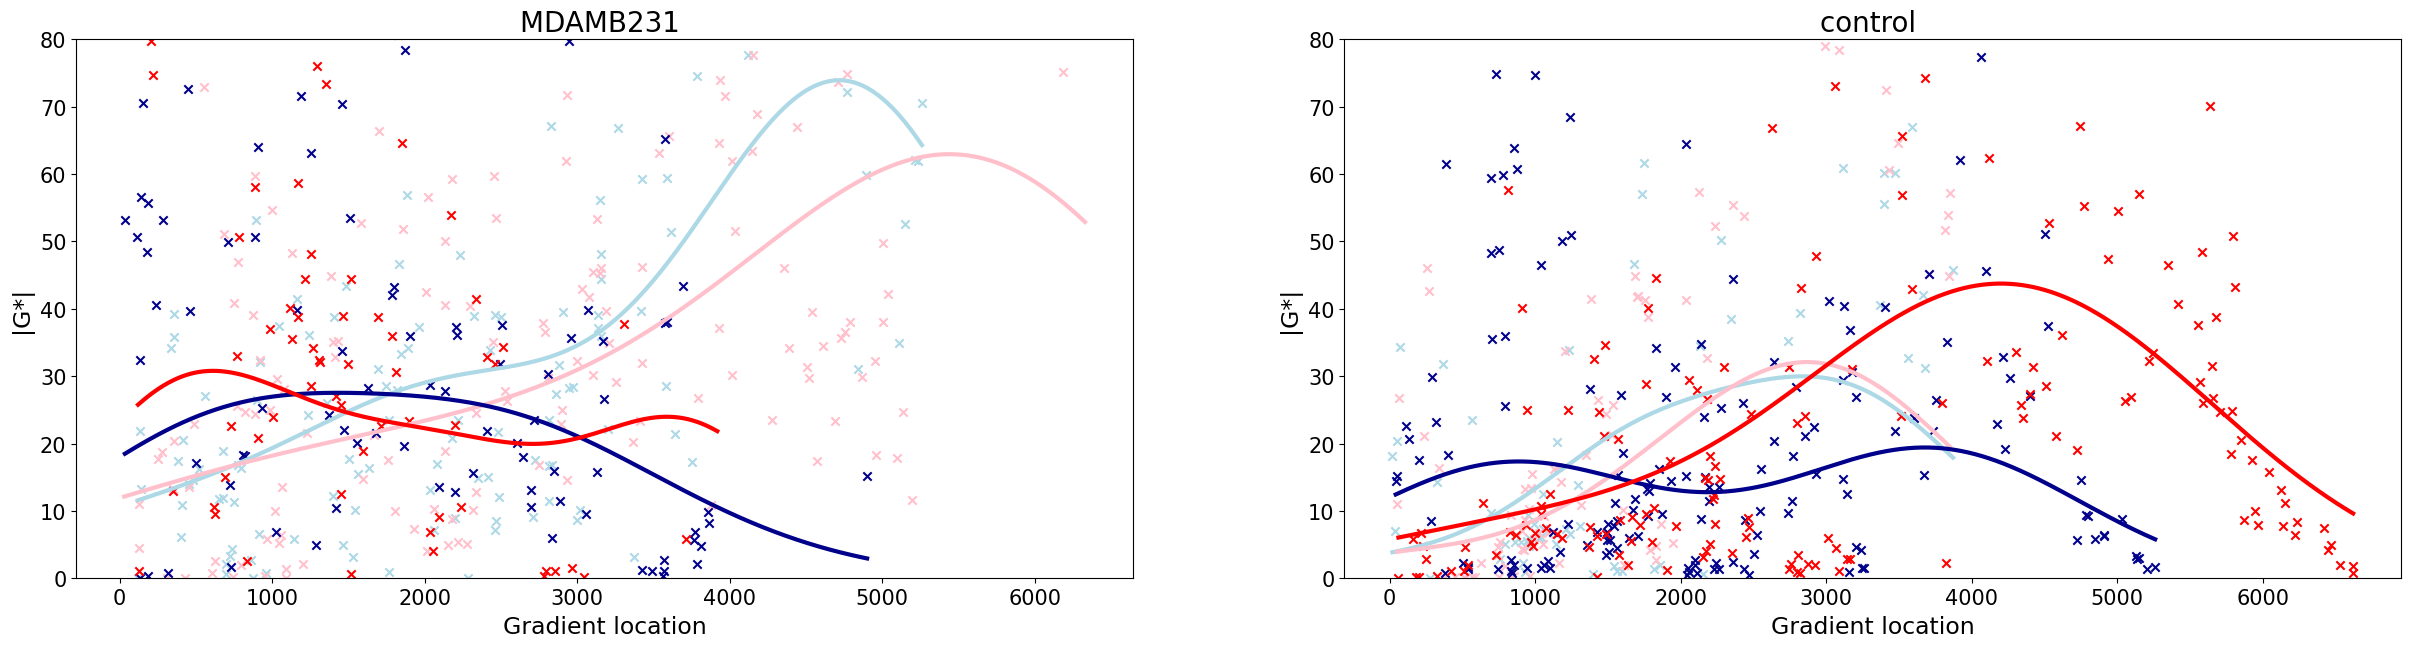

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(30, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","pink","darkblue","red"]

# for i,j in enumerate(download['incubation_set'].unique()):
#     first = download[download['incubation_set']==j]
#     row = i
        
for nn,n in enumerate(download['incubation'].unique()):
    second = download[download['incubation']==n]
    color_type = colors[int(nn)]
    #print(n, color)

    
    # for k,l in enumerate(second['experiment'].unique()):
    #     third = second[second['experiment']==l]
    #     marker_type = markers[l]
    #     row = (i*2)+(k)
    #     #print(l, marker_type)
    
    for m,o in enumerate(second['sample'].unique()):
        column = 0 if o=='MDAMB231' else 1
        fourth = second[second['sample']==o]
        #print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
        date_value = str(fourth['day'].unique()[0])
        ax = axs[column]
        #GLS_g(dfffff,ax,color)

        if (fourth['gradient_direction'] == 'stiff_to_soft').all():
            #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
            # filtered_data = fourth[(fourth['gradient'] > 800) & (fourth['gradient'] < 1200)]['G_abs']
            #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
            fitting_kernel(fourth['gradient'],fourth['G_abs'],ax,color_type,marker_type,10)
            
        else:
            #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
            fitting_kernel(fourth['gradient_inverse'],fourth['G_abs'],ax,color_type,marker_type, 30)

        ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
        ax.set_ylabel("|G*|", fontsize= 17, labelpad=5)
        ax.set_title(f"{o} ", fontsize = 20)
        ax.tick_params(axis='both', labelsize=15)
        
        ax.set_ylim (0,80) 
        #ax.set_xlim (0,5000)  
  
                

## GLS phase shift

In [89]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

alpha = 0.05

def GLS_phaseshift(data, ax, color):
    # Check for NaNs or infs in input data
    if data['f'].isnull().any() or data['phi_(rad)'].isnull().any():
        print("Data contains NaN values, which might cause issues.")
        return

    if (data['phi_(rad)'] <= 0).any():
        print("Data contains non-positive values in 'phi_(rad)', which will cause issues with log transformation.")
        return

    # Extract x and log-transform y
    x = data['f'].values.reshape(-1, 1)
    y = np.log(data['phi_(rad)'].values)

    # Fit GLS model
    x_const = sm.add_constant(x)
    modelGLS = sm.GLS(y, x_const)
    resultsGSL = modelGLS.fit()

    # Generate predictions
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)
    y_predictedGLS = np.exp(y_predictedGLS_log)

    # Prediction intervals
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # Plotting
    ax.scatter(data['f'], data['phi_(rad)'], s=4, c=color, label='Data')
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI, color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 5000)
    ax.legend()
    ax.set_xlabel("Frequency (f)")
    ax.set_ylabel("Phase (phi in rad)")

    print("Model fit successfully. Check plot for results.")


set 0, 120h, MDAMB231, [241111],['soft_to_stiff']
set 0, 120h, control, [241111],['soft_to_stiff']
set 1, 120h, control, [241125],['soft_to_stiff']
set 1, 120h, MDAMB231, [241125],['soft_to_stiff']

set 0, 24h, control, [241107],['soft_to_stiff']
set 0, 24h, MDAMB231, [241107],['soft_to_stiff']
set 1, 24h, MDAMB231, [241121],['soft_to_stiff']
set 1, 24h, control, [241121],['soft_to_stiff']

set 0, 48h, control, [241108],['soft_to_stiff']
set 0, 48h, MDAMB231, [241108],['soft_to_stiff']
set 1, 48h, MDAMB231, [241122],['soft_to_stiff']
set 1, 48h, control, [241122],['soft_to_stiff']

set 0, 144h, control, [241112],['soft_to_stiff']
set 0, 144h, MDAMB231, [241112],['soft_to_stiff']
set 1, 144h, MDAMB231, [241126],['soft_to_stiff']
set 1, 144h, control, [241126],['soft_to_stiff']



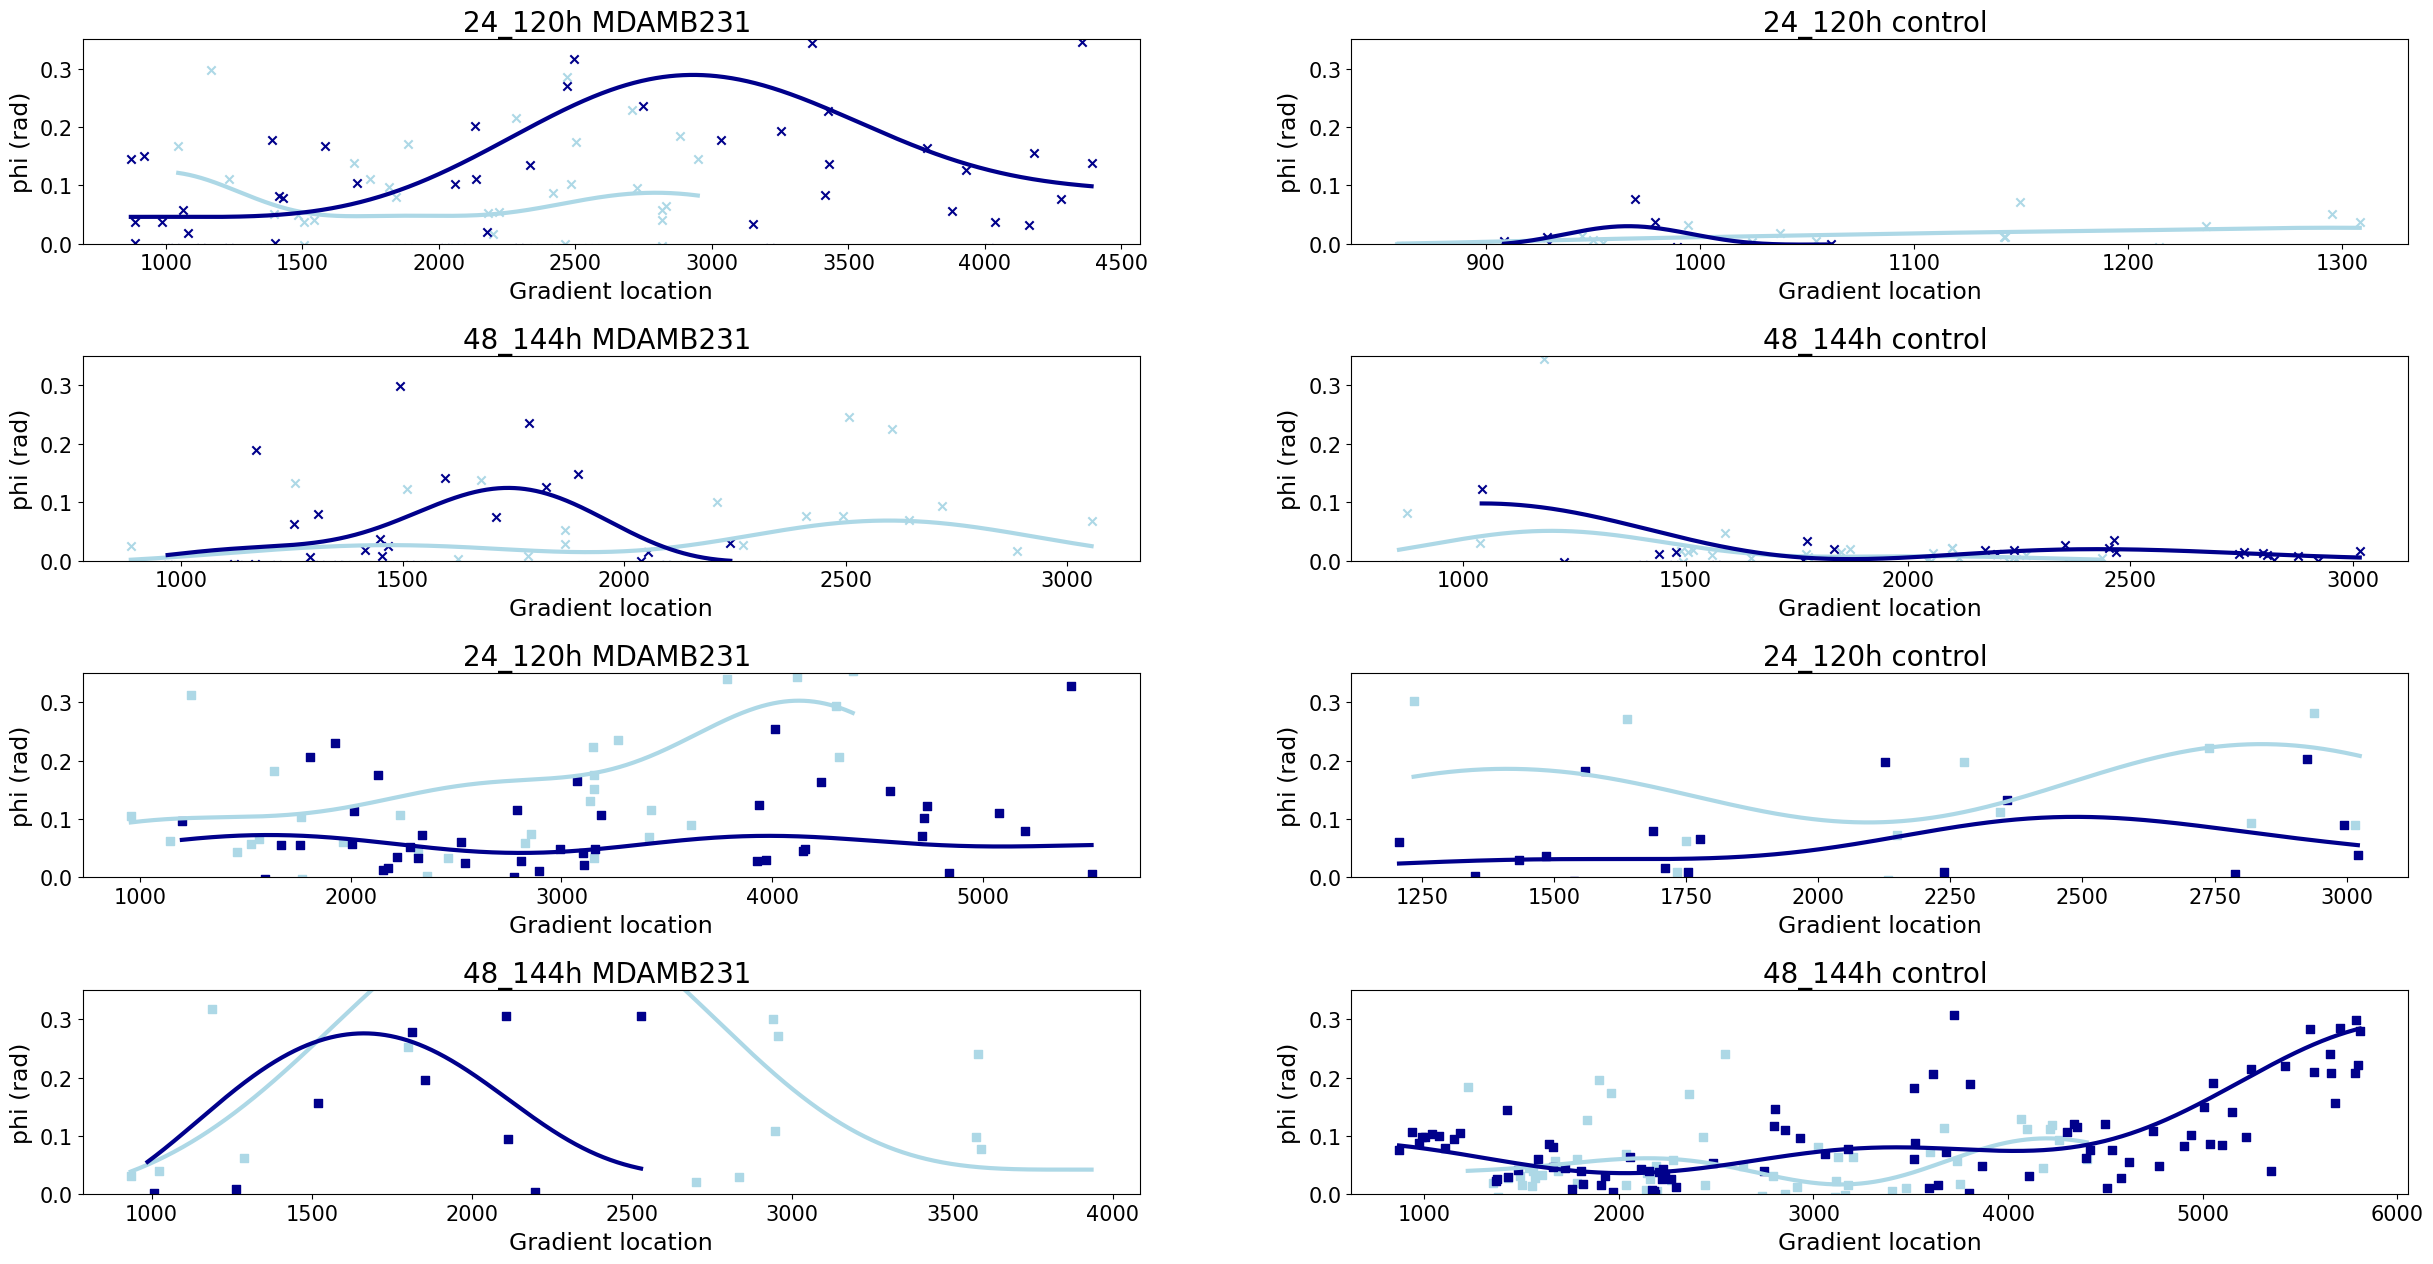

In [94]:
fig, axs = plt.subplots(4, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.55)
fig.suptitle("", fontsize=18, y=1)

markers=['x','s']

colors = ["lightblue","darkblue"]

for i,j in enumerate(download['incubation_set'].unique()):
    first = download[download['incubation_set']==j]
        
    for nn,n in enumerate(first['incubation'].unique()):
        second = first[first['incubation']==n]
        color_type = colors[int(nn)]
        #print(n, color)

        
        for k,l in enumerate(second['experiment'].unique()):
            third = second[second['experiment']==l]
            marker_type = markers[l]
            row = i+(2*k)
            #print(l, marker_type)
            
            for m,o in enumerate(third['sample'].unique()):
                column = 0 if o=='MDAMB231' else 1
                fourth = third[third['sample']==o]
                print(f"set {k}, {n}h, {o}, {str(fourth['day'].unique())},{fourth['gradient_direction'].unique()}")
                date_value = str(fourth['day'].unique()[0])
                ax = axs[row,column]
                #GLS_g(dfffff,ax,color)
                #print(dfffff)
                
                if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                    #ax.scatter(fourth['gradient'],fourth['G_abs'],s=35, c=color, marker = marker_type) #measured from soft to stiff 
                    filtered_data = fourth[(fourth['gradient'] > fourth['gradient'].min()+800) & (fourth['gradient'] < fourth['gradient'].max()-800)]
                    #fitting(ax,fourth['gradient'],fourth['G_abs'],color_type,marker_type)
                    fitting_kernel(filtered_data['gradient'],filtered_data['phi_(rad)'],ax,color_type,marker_type,1)
                    
                else:
                    #fitting(ax,fourth['gradient_inverse'],fourth['G_abs'],color_type, marker_type)
                    filtered_data = fourth[(fourth['gradient_inverse'] > fourth['gradient_inverse'].min()+800) & (fourth['gradient_inverse'] < fourth['gradient_inverse'].max()-800)]
                    fitting_kernel(filtered_data['gradient_inverse'],filtered_data['phi_(rad)'],ax,color_type,marker_type,1)
  
                ax.set_xlabel("Gradient location", fontsize= 17,labelpad=5)
                ax.set_ylabel("phi (rad)", fontsize= 17, labelpad=5)
                ax.set_title(f"{j}h {o} ", fontsize = 20)
                ax.tick_params(axis='both', labelsize=15)


                ax.set_ylim (0,0.35) 
                # ax.set_xlim (0,5000)  
                
        print()
                

Text(0.5, 1.0, 'Control sample 24h')

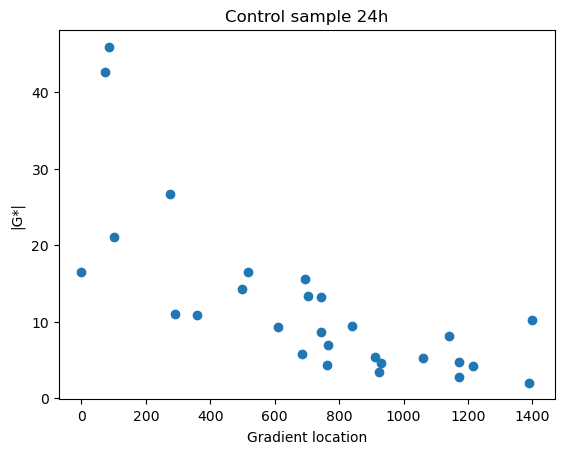

In [9]:
max = control['gradient'].max()
control['x_con'] = max -control['gradient']
control.to_csv('C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data/241107_24h_control', index=False)

plt.scatter(control['x_con'],control['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Control sample 24h')

In [55]:
paths_old = glob.glob(os.path.join("E:/Turku_collab/microrheometry/240912", "**","summary_ID_level.csv"),recursive=True)
print(*paths_old, sep='\n')
old_df = []


def parser(i):
    data = pd.read_csv(i)
    data['irradiation'] = (i.split('/')[3].split('\\')[1].split('_')[1])
    data['cell/control']=(i.split('/')[3].split('\\')[1].split('_')[2])
    return data
    
old_df = pd.concat([parser(i) for i in paths_old], ignore_index=True)
print(old_df['sample'].unique())
print(old_df['day'].unique())
print(old_df['holder'].unique())
print(old_df['irradiation'].unique())
print(old_df['cell/control'].unique())


E:/Turku_collab/microrheometry/240912\240912_50s_cell\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/240912\240912_70s_cell\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/240912\240913_50s_control\holder_1\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/240912\240913_50s_control\holder_2\results\summary_ID_level.csv
[3 2 1]
[240912 240913]
[1 2]
['50s' '70s']
['cell' 'control']


C:\Users\srboval1\AppData\Local\Temp\ipykernel_12028\2244405667.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend().remove()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_12028\2244405667.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend().remove()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_12028\2244405667.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend().remove()
C:\Users\srboval1\AppData\Local\Temp\ipykernel_12028\2244405667.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when l

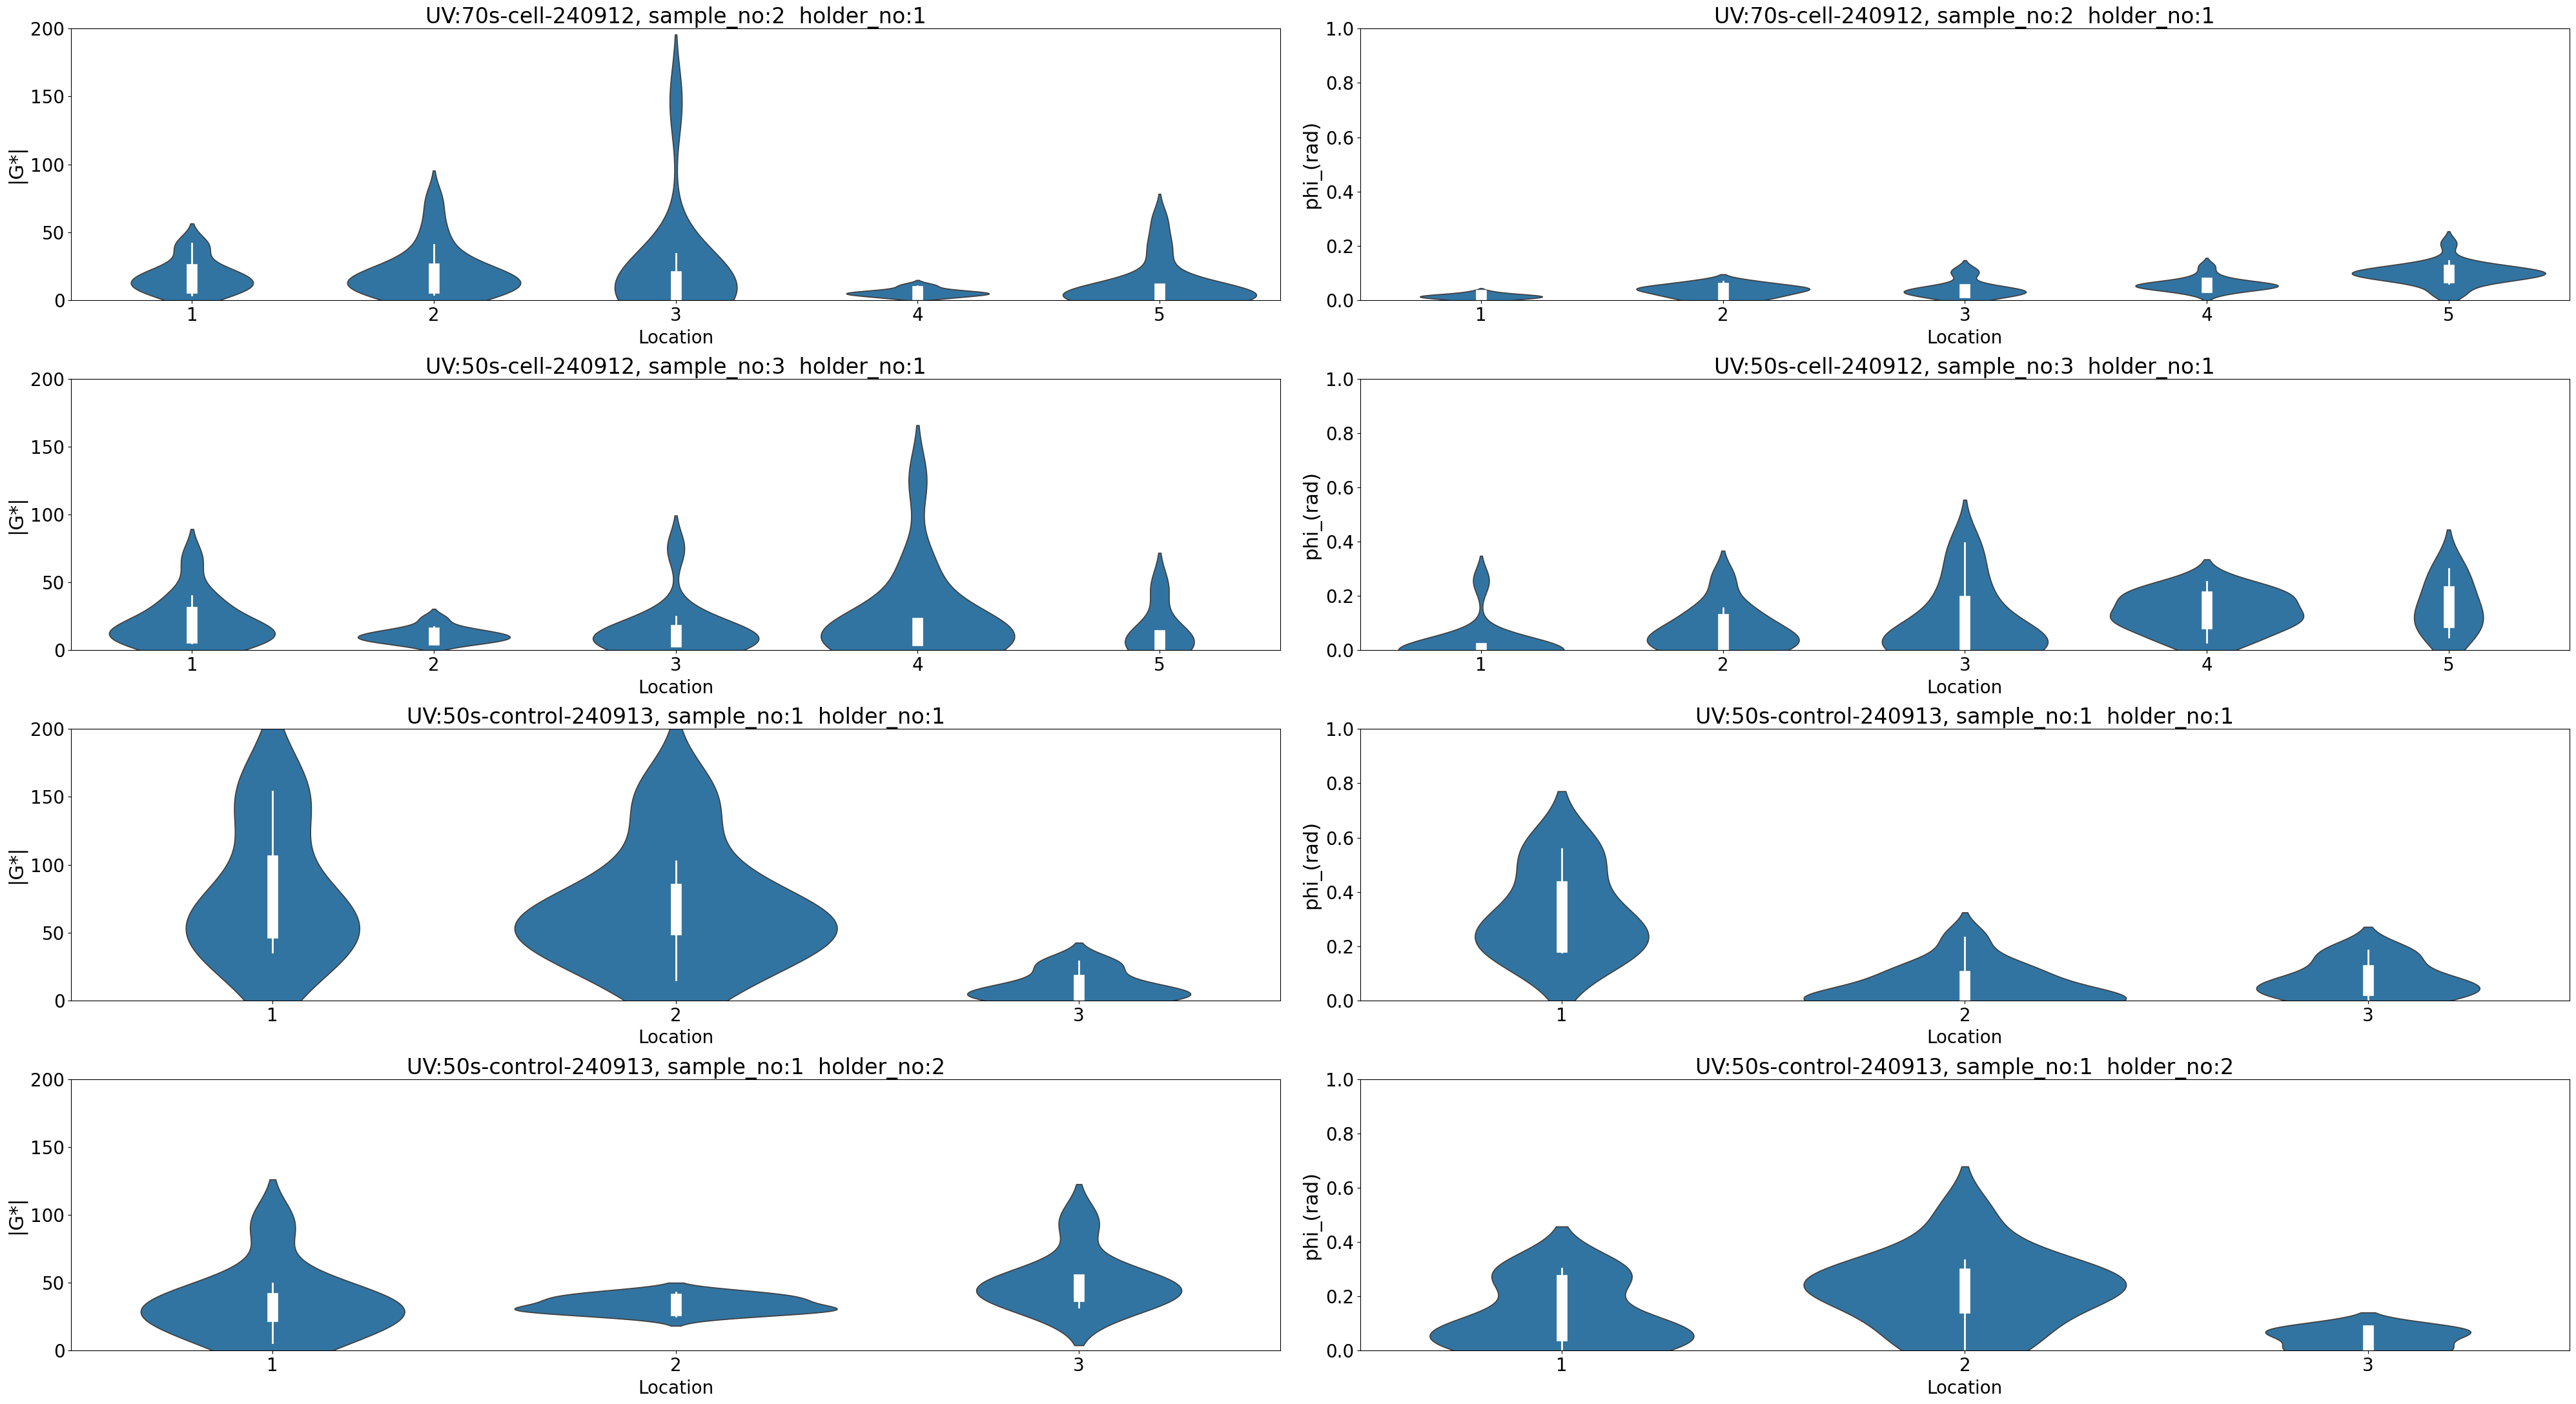

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the subplots
fig, axs = plt.subplots(4, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("", fontsize=22)

markers = ['x', 's']
colors = ["lightblue", "darkblue"]

def plotting(data,i,day, sample, holder, irradiation, cell_control):
    
    ax1 = axs[i, 0] 
    sns.violinplot(x='location', y='G_abs', data=data, 
                   inner='box', width=0.8, 
                   density_norm='count', ax=ax1, legend=True,inner_kws=dict(box_width=12, whis_width=2, color="1"))
        
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=22, labelpad=5)
    ax1.set_title(f"UV:{irradiation}-{cell_control}-{day}, sample_no:{sample}  holder_no:{holder}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.legend().remove()
    ax1.set_ylim(0, 200)

    ax2 = axs[i, 1]
    sns.violinplot(x='location', y='phi_(rad)', data=data, inner='box', width=0.8, 
                   density_norm='count', ax=ax2, legend=True,inner_kws=dict(box_width=12, whis_width=2, color="1"))
    ax2.set_xlabel("Location", fontsize=20, labelpad=5)
    ax2.set_ylabel("phi_(rad)", fontsize=22, labelpad=5)
    ax2.set_title(f"UV:{irradiation}-{cell_control}-{day}, sample_no:{sample}  holder_no:{holder}", fontsize=24)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.legend().remove()
    ax2.set_ylim(0, 1)
    
for i, ((day, sample, holder, irradiation, cell_control), group_data) in enumerate(old_df.groupby(['day', 'sample', 'holder', 'irradiation', 'cell/control'])):
    plotting(group_data, i,day, sample, holder, irradiation, cell_control)

# fig.legend(title="Incubation time", loc='upper center', title_fontsize=20, fontsize=20, ncol=2, bbox_to_anchor=(1.05, 0.95), frameon=False)

plt.tight_layout()
plt.show()
